# Misc. POPPIES data notebook (FH)

## Convert Data Files to WISP Format for Spectral Fitting

**Author:** Mitchell Revalski

**Adapted:** Kalina V. Nedkova and James Colbert

**Now Adapted:** Farhan Hasan

**Last Updated:** Jan 10, 2025

***

## Jupyter Notebook for the MUSE Ultra Deep Field Program

This notebook was created by Dr. Mitchell Revalski to convert the HST passage and VLT MUSE spectroscopic files provided by Dr. Nor Pirzkal and Dr. Matteo Fossati into a format that is compatible with the version of the WISP spectroscopic fitting routine that is being used for the MUDF program.

Please send questions, comments, and suggestions to Mitchell Revalski at [mrevalski@stsci.edu](mrevalski@stsci.edu). Thank you, and have a nice day!

***

## This version has been adapted for PASSAGE

The updated version of this notebook converts JWST 1D spectroscopic files produced by grizli into a format that is compatible with the version of the WISP spectroscopic fitting routine that is being used for the PASSAGE program.

Moreover, in an optional step 3, 1D spectroscopic files are created for the individual orientations (R grism & C grism). The location of the beam files from grizli needs to be specified for this step. 

Please send questions, comments, and suggestions w.r.t. the PASSAGE updates to Kalina at [knedkova@stsci.edu](knedkova@stsci.edu). 
Special thank you to James Colbert for fixing a bug that caused this code to crash if the F150W grism filter does not exist. 

***


## Software

The Python environment (ac6) used to run this notebook was built using conda:<br>
<code>
(base) asteropaios:Documents mrevalski$ conda create -n ac6 stsci
(base) asteropaios:Documents mrevalski$ conda activate ac6
(ac6) asteropaios:Documents mrevalski$ conda update drizzlepac
(ac6) asteropaios:Documents mrevalski$ conda deactivate
</code>

The jupyter notebook can then be run using the following call sequence:<br>
<code>
(base) asteropaios:conversion mrevalski$ conda activate ac6
(ac6) asteropaios:conversion mrevalski$ jupyter notebook
</code>

The critical package versions include:<br>
<code>
Python Version [GCC Clang 10.0.0] 3.6.13 |Anaconda, Inc.|
(default, Feb 23 2021, 12:58:59) 
numpy Version -> 1.19.2 
astropy Version -> 4.0.2
</code>  

***

## Table of Contents <a class="anchor" id="tag0"><a>


**&emsp; 1) [Setup Options](#setup)<br>**
**&emsp; 2) [Convert PASSAGE](#passage)<br>**
**&emsp; 3) [Create 1D spectra for each orientation](#orientations)<br>**
    
*** 

## Imports

The following packages are required to run the Jupyter Notebook:
 - *os* - change and make directories
 - *glob* - determine files in folders
 - *numpy* - math and array functions
 - *pandas* - data structure functions    
 - *astropy* - file and data handling
      - *io.fits* - import FITS files
      - *table.Table* - display formatted tables

In [1]:
import os
import glob
import numpy as np
import pandas as pd
from astropy.io import fits, ascii
from astropy.table import Table, vstack
import astropy.units as u
from scipy import interpolate
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.coordinates import SkyCoord

from time import time

import grizli
print(grizli.__version__)

from grizli import utils, multifit
from grizli.pipeline import auto_script

import glob

from specutils import Spectrum1D
from specutils.manipulation import gaussian_smooth, FluxConservingResampler, LinearInterpolatedResampler


utils.set_warnings()

1.12.8
Failed to `import dust_attenuation`
Install from the repo with $ pip install git+https://github.com/karllark/dust_attenuation.git


### Matching objects between two catalogs (two different filters)

In [3]:
f444w = ascii.read('/Users/fhasan/Desktop/Research_STScI/POPPIES/Data/Par002/jw05398033_F444W_i2d.cat')

f277w = ascii.read('/Users/fhasan/Desktop/Research_STScI/POPPIES/Data/Par002/jw05398035_F277W_i2d.cat')

c1 = SkyCoord(f277w['RA']*u.deg,f277w['DEC']*u.deg, frame='icrs')
c2 = SkyCoord(f444w['RA']*u.deg,f444w['DEC']*u.deg, frame='icrs')

# sep = c1.separation(c2)
# sep  

# for i in c1:
#     sp = i.separation(c2)
#     print(np.min(sp.arcsecond))

idx, d2d, d3d = c1.match_to_catalog_sky(c2)


In [18]:
inds = np.where(idx == 3)[0]

max_a = 0.1 #arcsec

ids_match = []

for num,i,a in enumerate(zip(idx, d2d.arcsecond)):

    if a <= max_a:
        ids_match.append(i)

        .append(num)


ids_match = np.unique(ids_match)

print(len(ids_match))
        
    

# arcsecs = np.where(d2d.arcsecond < 2)

# arcsecs_unique = np.unique(arcsecs)

# len(arcsecs_unique), len(arcsecs)


728


In [41]:
np.where(d2d.arcsecond < 2)

(array([   0,    1,    2, ..., 2514, 2515, 2516]),)

## Setup Options  <a class="anchor" id="setup"><a>
[Table of Contents](#tag0)

In [21]:
# main directory
research_directory = '/Users/fhasan/Desktop/Research_STScI/'
main_directory = '/Users/fhasan/Desktop/Research_STScI/POPPIES/'
par_names = ['002']

par_names_2 = ['Par052']

# # grism data directory
# spec1D_directory = main_directory+'Data/'+par_names[0]+'/spec1D/'

# # where all the parallel field data live
# data_directory = main_directory+'Data/'+par_names[0]+'/'

# grism data directory
# spec1D_directory = main_directory+'ReducedData_downloadedcopy/'+par_names[0]+'/spec1D/'

# where all the parallel field data live
# data_directory = main_directory+'ReducedData_downloadedcopy/v0.2/'+par_names[0]+'/'

data_directory = main_directory+'ReducedData_downloadedcopy/v0.2/'+par_names[0]+'/jw05398033_jw05398030_ext/'

data_directory_2 = main_directory+'Data/Par'+par_names[0]+'/'

In [23]:
# os.chdir(spec1D_directory)

### FH testing FITS files below



In [28]:
f0 = fits.open(data_directory+'A_F444W_R_1332.V4.fits')

f2 = fits.open(research_directory+'PASSAGE/Data/' +par_names_2[0]+ '/spec1D/'+par_names_2[0]+'_00005.spec1D.fits') ## open PASSAGE FITS file for reference

f3 = fits.open(research_directory+'PASSAGE/Data/' +par_names_2[0]+ '/spec2D/'+par_names_2[0]+'_00005.spec2D.fits') ## open PASSAGE FITS file for reference


# f4 = fits.open(research_directory+'PASSAGE/Data/'+par_names_2[0]+ '/DATA/'+par_names_2[0]+'_f150w-gr150r_drz_sci.fits') ## open PASSAGE FITS file for reference


# g = fits.open(data_directory+'A/'+'jw05398040_A_F444W_i2d.fits')

# for i in range(len(hdulist)):
#     header = f[i].header

print('POPPIES\n',f0[1].header)
print('\n')

print('PASSAGE\n',f2[1].header)

POPPIES
 XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                  104 / length of dimension 1                          NAXIS2  =                 1408 / length of dimension 2                          PCOUNT  =                    0 / number of group parameters                     GCOUNT  =                    1 / number of groups                               TFIELDS =                   13 / number of table fields                         TTYPE1  = 'WAVELENGTH'                                                          TFORM1  = 'D       '                                                            TTYPE2  = 'COUNT   '                                                            TFORM2  = 'D       '                                                            TTYPE3  = 'ERR     '           

In [72]:
f3[29].header, g[1].header, 


if f0[2].header['EXTNAME'] in ["2D_COUNT"]:
    print('hah')

hah


In [30]:
f0.info(), f2.info(), f3.info()

Filename: /Users/fhasan/Desktop/Research_STScI/POPPIES/ReducedData_downloadedcopy/v0.2/002/jw05398033_jw05398030_ext/A_F444W_R_1332.V4.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     34   1408R x 13C   [D, D, D, D, D, D, D, D, D, D, D, D, D]   
  2  2D_COUNT      1 ImageHDU        20   (1408, 200)   float64   
  3  2D_ERR        1 ImageHDU        20   (1408, 200)   float64   
  4  2D_TCOUNT     1 ImageHDU        20   (1408, 200)   float64   
  5  2D_CCOUNT     1 ImageHDU        20   (1408, 200)   float64   
  6  2D_MCOUNT     1 ImageHDU        20   (1408, 200)   float64   
  7  2D_WAVE       1 ImageHDU        20   (1408, 200)   float64   
Filename: /Users/fhasan/Desktop/Research_STScI/PASSAGE/Data/Par052/spec1D/Par052_00005.spec1D.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      19   ()      
  1  F115W         1 BinTableHDU  

(None, None, None)

In [60]:
f3[2].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   78                                                  
NAXIS2  =                   64                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
CRPIX1  =                   40                                                  
CRPIX2  =                   33                                                  
CRVAL1  =                1.145                                                  
CD1_1   =               0.0045                                                  
CD1_2   =                  0.0                                                  
CRVAL2  =                  0

In [62]:
f0[2].header

# f3[2].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1408                                                  
NAXIS2  =                  200                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
EXTNAME = '2D_ERR  '                                                            
CRPIX1  =                   72                                                  
CRVAL1  =    3.810814380645752                                                  
CDELT1  =                0.001                                                  
CRPIX2  =                100.5                                                  
CRVAL2  =                   

In [52]:
seg1 = fits.open(data_directory+'A/'+'jw05398040_A_F444W_segm.fits')

# seg1 = fits.open(data_directory+'A/'+'jw05398040_A_F444W_i2d_seg.fits')

seg2 = fits.open(research_directory+'PASSAGE/Data/Par28/'+'Par28_comb_seg.fits') ## open PASSAGE FITS file for reference

np.shape(seg1[0].data), np.shape(seg2[0].data)

seg1.info(), seg2.info()

Filename: /Users/fhasan/Desktop/Research_STScI/POPPIES/ReducedData_downloadedcopy/040/A/jw05398040_A_F444W_segm.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     364   ()      
  1  SCI           1 ImageHDU        31   (2082, 2083)   int32 (rescales to uint32)   
  2  ASDF          1 BinTableHDU     11   1R x 1C   [11925B]   
Filename: /Users/fhasan/Desktop/Research_STScI/PASSAGE/Data/Par28/Par28_comb_seg.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   (6210, 6203)   int32   


(None, None)

In [54]:
seg1[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
DATE    = '2024-10-21T21:08:53.682' / UTC date file created                     
ORIGIN  = 'STSCI   '           / Organization responsible for creating file     
TIMESYS = 'UTC     '           / principal time system for time-related keywords
TIMEUNIT= 's       '           / Default unit applicable to all time values     
FILENAME= 'jw05398040_A_F444W_segm.fits' / Name of the file                     
SDP_VER = '2024_2b '           / Data processing (DP) Software Version          
PRD_VER = 'PRDOPSSOC-067'      / S&OC Project Reference Database (PRD) Version  
OSS_VER = '10.0    '           / Observatory Scheduling Software (OSS) Version  
GSC_VER = 'GSC30   '        

In [97]:
phcat = ascii.read(data_directory+'A/'+'jw05398040_A_F444W_i2d.cat')

phcat2 = fits.open(research_directory+'PASSAGE/Data/Par28/DATA/DIRECT_GRISM/'+'Par28_photcat.fits') ## open PASSAGE FITS file for reference


In [119]:
phcat

<Table length=740>
 X_IMAGE   Y_IMAGE  MAG_AUTO NUMBER ... FLAGS_WIN FLUX_APER FLUXERR_APER
   pix       pix      mag           ...               ct         ct     
 float64   float64  float64  int64  ...   int64    float64    float64   
--------- --------- -------- ------ ... --------- --------- ------------
  668.511   90.2755  -9.4747      1 ...         0  91.26967   0.01994647
 429.8721  117.1273  -6.8512      2 ...         0  36.95193   0.01990572
  12.0029   97.9685  -4.4214      3 ...         0  2.425696   0.01998714
1958.0482   53.5502  -6.1145      4 ...         0  60.25308   0.02000744
 319.0848   29.1825  -4.8156      5 ...         0  13.27138   0.01996681
1168.7458   32.2861  -2.9248      6 ...         0  7.775646   0.01986489
 999.2064   22.4789  -3.4041      7 ...         0  3.623096   0.01998714
1300.5029   25.6824  -3.2985      8 ...         0  6.203098   0.01990572
  35.6045   24.3059  -2.5556      9 ...         0  3.205132   0.01992611
      ...       ...      ...    ... ...       ...       ...          ...
1047.1555 1968.4824  -0.2609    732 ...         0 0.5105052   0.01994647
1938.0105 1985.4822  -0.1617    733 ...         0 0.5321631   0.01998714
1365.1571 1990.3302  -3.3603    734 ...         0   4.96898   0.01998714
1499.8351 1770.2893   -0.727    735 ...         0 0.9728175   0.01994647
1643.8738 1994.5758  -2.5217    736 ...         0  4.934778   0.01998714
  98.9822 1940.7047  -0.2367    737 ...         0 0.6693016   0.01994647
 236.8352 1983.1644  -3.5122    738 ...         0  1.243901   0.02000744
 402.9801 1486.5693  -1.7005    739 ...         0  2.684791   0.01996681
1655.2311 1918.9009  -0.1109    740 ...         0 0.6833827   0.01992611

In [136]:
spec_cat =  glob.glob(data_directory_2+'DATA/DIRECT_GRISM/*_A_*_i2d.cat') 

spec_cat

['/Users/fhasan/Desktop/Research_STScI/POPPIES/Data/Par040/DATA/DIRECT_GRISM/jw05398040_A_F444W_i2d.cat']

## Convert POPPIES  <a class="anchor" id="passage"><a>
[Table of Contents](#tag0)

1. In order for the wavelet solutions to work, the 'RADESYS' keyword in the header must be either updated or removed. 

In [37]:
#check if already updated for first object. If yes -> do nothing, if not -> update RADESYS in all fits headers

# for k in par_names:
#     files = glob.glob(main_directory+'Data/Par'+str(k)+'/spec2D/*.fits')
#     test_file = fits.open(files[0])
#     header = test_file[2].header
    
#     if header['RADESYS'] != 'ICRS':
#         print('Headers are not updated. Updating all now.')
#         hdulist = fits.open(main_directory+'Data/'+str(k)+'/spec2D/*.fits')

#         for j in files:
#             # Open the file header for viewing and load the header
#             hdulist = fits.open(j)
#             for i in range(len(hdulist)):
#                 header = hdulist[i].header
#                 try: header['RADESYS'] = 'ICRS'
#                 except: print('no RADESYS in header')
            
#             hdulist.writeto(j, overwrite='True')


k = 40

# for k in par_names:


files = glob.glob(main_directory+'Data/Par'+str(k)+'/spec1D/*.fits')


for i in range(len(files)):

    print(files[i])
    test_file = fits.open(files[i])
    header = test_file[2].header

    if header['RADESYS'] != 'ICRS':
        print('Header not updated. Updating now.')
        hdulist = fits.open(main_directory+'Data/Par'+str(k)+'/spec1D/*.fits')
        try: header['RADESYS'] = 'ICRS'
        except: print('no RADESYS in header')

    test_file.writeto(files[i], overwrite='True')

# print(test_file.info(), header['RADESYS'])

# if header['RADESYS'] != 'ICRS':
#     print('Headers are not updated. Updating all now.')
#     hdulist = fits.open(main_directory+'Data/'+str(k)+'/spec2D/*.fits')

#     for j in files:
#         # Open the file header for viewing and load the header
#         hdulist = fits.open(j)
#         for i in range(len(hdulist)):
#             header = hdulist[i].header
#             try: header['RADESYS'] = 'ICRS'
#             except: print('no RADESYS in header')
        
#         hdulist.writeto(j, overwrite='True')


/Users/fhasan/Desktop/Research_STScI/POPPIES/Data/Par40/spec1D/A_F444W_GRISMC_350.V4.fits


KeyError: "Keyword 'RADESYS' not found."

### Smooth the spectra

In [77]:
# ### function from MDR for MUDF project:


# def resample_muse_spectra(idx, verbose = False):

#     main_dir = '/Users/mrevalski/Documents/stsci/research/mudf/analysis/metallicity'
#     plot_dir = main_dir+'/plots'
#     run11_dir = main_dir+'/run11/wisp_analysis/'
#     from scipy import interpolate
    
#     if (verbose == True):
#         print('Resampling MUSE Spectra for object', idx)
    
#     import numpy as np
#     import astropy.units as u
#     from specutils import Spectrum1D
#     from specutils.manipulation import gaussian_smooth, FluxConservingResampler, LinearInterpolatedResampler

#     #idx = 856
#     specfile = run11_dir + 'Par0/Spectra/Par0_output_run11_final/fitdata/' + 'mudf_' + str(idx) + '_fitspec.dat' #M.D.R#
#     specdata = asciitable.read(specfile, fill_values=[('--', '-99')])

#     ##### get spectrum
#     lam_spec = specdata['Lam']
#     flam_spec = specdata['Flam']
#     flam_spec_err = specdata['Flam_err']
#     mask_spec = specdata['Masked']
#     cont_spec = specdata['Contmodel']    
#     contam_spec = specdata['Contam']
    
#     if (lam_spec[0] > 9500): # if no muse spectrum for this object.
#         if (verbose == True):
#             print('NO MUSE SPECTRUM FOR THIS OBJECT.')
#         return lam_spec, flam_spec, flam_spec_err, cont_spec, mask_spec

#     lamb1 = lam_spec[0:3796] * u.AA
#     flux1 = flam_spec[0:3796] * u.Unit('erg cm-2 s-1 AA-1')
#     ferr1 = flam_spec_err[0:3796] * u.Unit('erg cm-2 s-1 AA-1')
#     cont1 = cont_spec[0:3796] * u.Unit('erg cm-2 s-1 AA-1')
#     mask1 = mask_spec[0:3796]

#     lamb2 = lam_spec[3796:len(lam_spec)] * u.AA
#     flux2 = flam_spec[3796:len(flam_spec)] * u.Unit('erg cm-2 s-1 AA-1')
#     ferr2 = flam_spec_err[3796:len(flam_spec_err)] * u.Unit('erg cm-2 s-1 AA-1')
#     cont2 = cont_spec[3796:len(cont_spec)] * u.Unit('erg cm-2 s-1 AA-1')
#     mask2 = mask_spec[3796:len(mask_spec)]

#     input_spec = Spectrum1D(spectral_axis=lamb1, flux=flux1)
#     input_ferr = Spectrum1D(spectral_axis=lamb1, flux=ferr1)
#     input_cont = Spectrum1D(spectral_axis=lamb1, flux=cont1)

#     # Smoothed.
#     spec1_gsmooth = gaussian_smooth(input_spec, stddev=(21.5/1.25)) # set based on grism and confirm flux conservation.
#     ferr1_gsmooth = gaussian_smooth(input_ferr, stddev=(21.5/1.25)) # set based on grism and confirm flux conservation.
#     cont1_gsmooth = gaussian_smooth(input_cont, stddev=(21.5/1.25)) # set based on grism and confirm flux conservation.

#     # Resampled.
#     new_disp_grid = np.arange(lam_spec[0], lam_spec[3796], 21.5) * u.AA
#     #print('The new grid has length:', len(new_disp_grid))
#     fluxcon = FluxConservingResampler()
#     new_spec_fluxcon = fluxcon(spec1_gsmooth, new_disp_grid)
#     new_ferr_fluxcon = fluxcon(ferr1_gsmooth, new_disp_grid)
#     new_cont_fluxcon = fluxcon(cont1_gsmooth, new_disp_grid)
    
#     # Masks.
#     mask_func = interpolate.interp1d(lam_spec, mask_spec, fill_value = -1, bounds_error = False, kind = 'nearest')
#     mask_new = mask_func(new_disp_grid)
#     #print('Mask before resamp:', mask_spec)
#     #print('Mask after resamp:', mask_new)
#     #print('length of new Mask:', len(mask_new))
#     #print('Type:', type(mask_new), type(mask2.value))
#     mask_resamp = np.concatenate((np.array(mask_new), np.array(mask2.value)))
    
#     # Replace flux values.
#     spec1 = Spectrum1D(spectral_axis=new_spec_fluxcon.spectral_axis, flux=new_spec_fluxcon.flux)
#     spec2 = Spectrum1D(spectral_axis=lamb2, flux=flux2)
#     new_spectral_axis = np.concatenate([spec1.spectral_axis.value, spec2.spectral_axis.to_value(spec1.spectral_axis.unit)]) * spec1.spectral_axis.unit
#     resampler = LinearInterpolatedResampler(extrapolation_treatment='zero_fill')
#     new_spec1 = resampler(spec1, new_spectral_axis)
#     new_spec2 = resampler(spec2, new_spectral_axis)
#     final_spec = new_spec1 + new_spec2

#     # Replace ferr values.
#     ferr1 = Spectrum1D(spectral_axis=new_ferr_fluxcon.spectral_axis, flux=new_ferr_fluxcon.flux)
#     ferr2 = Spectrum1D(spectral_axis=lamb2, flux=ferr2)
#     new_ferr_axis = np.concatenate([ferr1.spectral_axis.value, ferr2.spectral_axis.to_value(ferr1.spectral_axis.unit)]) * ferr1.spectral_axis.unit
#     resampler = LinearInterpolatedResampler(extrapolation_treatment='zero_fill')
#     new_ferr1 = resampler(ferr1, new_spectral_axis)
#     new_ferr2 = resampler(ferr2, new_spectral_axis)
#     final_ferr = new_ferr1 + new_ferr2
    
#     # Replace cont values.
#     cont1 = Spectrum1D(spectral_axis=new_cont_fluxcon.spectral_axis, flux=new_cont_fluxcon.flux)
#     cont2 = Spectrum1D(spectral_axis=lamb2, flux=cont2)
#     new_cont_axis = np.concatenate([cont1.spectral_axis.value, cont2.spectral_axis.to_value(cont1.spectral_axis.unit)]) * cont1.spectral_axis.unit
#     resampler = LinearInterpolatedResampler(extrapolation_treatment='zero_fill')
#     new_cont1 = resampler(cont1, new_spectral_axis)
#     new_cont2 = resampler(cont2, new_spectral_axis)
#     final_cont = new_cont1 + new_cont2

#     # Plot the original and resampled.
#     f, ax = matplotlib.pyplot.subplots(figsize=(11,6))
#     ax.step(final_spec.spectral_axis, final_spec.flux, where='mid', c='k', lw=2)
#     ax.step(spec1.spectral_axis, spec1.flux, ls='--', where='mid', lw=1) 
#     ax.step(spec2.spectral_axis, spec2.flux, ls='--', where='mid', lw=1)
#     ax.step(input_spec.spectral_axis, input_spec.flux, label='MUSE', color='C0', zorder=-3) # original
#     ax.set_xlim([4000, 17000])
#     ax.set_ylim([-2.0e-19, 8.0e-19])
#     ax.step(lam_spec, flam_spec_err, label='Error (original)', color='purple', zorder=-2)
#     ax.step(final_ferr.spectral_axis, final_ferr.flux, ls='--', where='mid', c='C2', lw=2, zorder=-2)
#     #ax.step(lam_spec, cont_spec, label='Continuum (original)', color='gold', zorder=-2)
#     #ax.step(final_cont.spectral_axis, final_cont.flux, ls='--', where='mid', c='C2', lw=2, zorder=-2)    
#     #matplotlib.pyplot.show()
#     matplotlib.pyplot.close()
    
#     return final_spec.spectral_axis.value, final_spec.flux.value, final_ferr.flux.value, final_cont.flux.value, mask_resamp


In [307]:
# New function appropriate for POPPIES:


def resample_spectra_eg(idx, disp_blue=10, disp_red=10, verbose = True, plots=False):

    # main_dir = main_directory
    # plot_dir = main_dir+'/plots'
    run_dir = main_directory + 'Data/{}'.format(str(par_names[0])) + '/spec1D/' 

    if (verbose == True):
        print('Resampling POPPIES Spectra for object ', idx)
    
    specfile = run_dir + 'A_F444W_GRISMR_{}.V4.fits'.format(str(idx))

    fff = fits.open(specfile)
    
    ext = 1
    
    specdata = Table.read(fff[ext], format='fits')
    # specdata = pd.DataFrame({})

    # print(specdata)
    
    # specdata = asciitable.read(specfile, fill_values=[('--', '-99')])

    # dtype=(numpy.record, [('WAVELENGTH', '>f8'), ('COUNT', '>f8'), ('ERR', '>f8'), ('MODEL', '>f8'), ('MODELFLUX', '>f8'), ('CONTAM', '>f8'), ('CONTAMFLUX', '>f8'), ('OPT', '>f8'), ('TFLUX', '>f8'), ('FLUX', '>f8'), ('OPTFLUX', '>f8'), ('FLUXERR', '>f8'), ('OPTFLUXERR', '>f8')]))

    ##### get spectrum
    lam_spec = specdata['WAVELENGTH'] * 10000  ## micron to AA
    flam_spec = specdata['OPTFLUX']
    flam_spec_err = specdata['OPTFLUXERR']
    # mask_spec = specdata['Masked']
    cont_spec = specdata['MODELFLUX']    
    contam_spec = specdata['CONTAMFLUX']

    good_inds = np.where((~np.isnan(lam_spec))&(~np.isnan(flam_spec)))[0]
    
    # if (lam_spec[0] > 9500): # if no muse spectrum for this object.
    #     if (verbose == True):
    #         print('NO MUSE SPECTRUM FOR THIS OBJECT.')
    #     return lam_spec, flam_spec, flam_spec_err, cont_spec, mask_spec

    lamb1 = lam_spec[good_inds] * u.AA
    flux1 = flam_spec[good_inds] * u.Unit('erg cm-2 s-1 AA-1')
    ferr1 = flam_spec_err[good_inds] * u.Unit('erg cm-2 s-1 AA-1')
    cont1 = cont_spec[good_inds] * u.Unit('erg cm-2 s-1 AA-1')
    # mask1 = mask_spec

    # lamb2 = lam_spec[3796:len(lam_spec)] * u.AA
    # flux2 = flam_spec[3796:len(flam_spec)] * u.Unit('erg cm-2 s-1 AA-1')
    # ferr2 = flam_spec_err[3796:len(flam_spec_err)] * u.Unit('erg cm-2 s-1 AA-1')
    # cont2 = cont_spec[3796:len(cont_spec)] * u.Unit('erg cm-2 s-1 AA-1')
    # mask2 = mask_spec[3796:len(mask_spec)]
    
    input_spec = Spectrum1D(spectral_axis=lamb1, flux=flux1)
    input_ferr = Spectrum1D(spectral_axis=lamb1, flux=ferr1)
    input_cont = Spectrum1D(spectral_axis=lamb1, flux=cont1)

    # Smoothed.
    spec1_gsmooth = gaussian_smooth(input_spec, stddev=(disp_blue/disp_red)) # set based on grism and confirm flux conservation.
    ferr1_gsmooth = gaussian_smooth(input_ferr, stddev=(disp_blue/disp_red)) # set based on grism and confirm flux conservation.
    cont1_gsmooth = gaussian_smooth(input_cont, stddev=(disp_blue/disp_red)) # set based on grism and confirm flux conservation.

    # Resampled.
    new_disp_grid = np.arange(lam_spec[good_inds][0], lam_spec[good_inds][-1], 10) * u.AA
    #print('The new grid has length:', len(new_disp_grid))
    fluxcon = FluxConservingResampler()
    new_spec_fluxcon = fluxcon(spec1_gsmooth, new_disp_grid)
    new_ferr_fluxcon = fluxcon(ferr1_gsmooth, new_disp_grid)
    new_cont_fluxcon = fluxcon(cont1_gsmooth, new_disp_grid)
    
    # # Masks.
    # mask_func = interpolate.interp1d(lam_spec, mask_spec, fill_value = -1, bounds_error = False, kind = 'nearest')
    # mask_new = mask_func(new_disp_grid)
    # #print('Mask before resamp:', mask_spec)
    # #print('Mask after resamp:', mask_new)
    # #print('length of new Mask:', len(mask_new))
    # #print('Type:', type(mask_new), type(mask2.value))
    # mask_resamp = np.concatenate((np.array(mask_new), np.array(mask2.value)))
    
    # Replace flux values.
    spec1 = Spectrum1D(spectral_axis=new_spec_fluxcon.spectral_axis, flux=new_spec_fluxcon.flux)
    # spec2 = Spectrum1D(spectral_axis=lamb2, flux=flux2)
    # new_spectral_axis = np.concatenate([spec1.spectral_axis.value, spec2.spectral_axis.to_value(spec1.spectral_axis.unit)]) * spec1.spectral_axis.unit
    new_spectral_axis = spec1.spectral_axis.value * spec1.spectral_axis.unit

    resampler = LinearInterpolatedResampler(extrapolation_treatment='zero_fill')
    new_spec1 = resampler(spec1, new_spectral_axis)
    # new_spec2 = resampler(spec2, new_spectral_axis)
    # final_spec = new_spec1 + new_spec2
    final_spec = new_spec1

    # Replace ferr values.
    ferr1 = Spectrum1D(spectral_axis=new_ferr_fluxcon.spectral_axis, flux=new_ferr_fluxcon.flux)
    # ferr2 = Spectrum1D(spectral_axis=lamb2, flux=ferr2)
    # new_ferr_axis = np.concatenate([ferr1.spectral_axis.value, ferr2.spectral_axis.to_value(ferr1.spectral_axis.unit)]) * ferr1.spectral_axis.unit
    new_ferr_axis = ferr1.spectral_axis.value * ferr1.spectral_axis.unit

    resampler = LinearInterpolatedResampler(extrapolation_treatment='zero_fill')
    new_ferr1 = resampler(ferr1, new_spectral_axis)
    
    # new_ferr2 = resampler(ferr2, new_spectral_axis)
    final_ferr = new_ferr1 

    
    # Replace cont values.
    cont1 = Spectrum1D(spectral_axis=new_cont_fluxcon.spectral_axis, flux=new_cont_fluxcon.flux)
    # cont2 = Spectrum1D(spectral_axis=lamb2, flux=cont2)
    new_cont_axis = cont1.spectral_axis.value * cont1.spectral_axis.unit
    resampler = LinearInterpolatedResampler(extrapolation_treatment='zero_fill')
    new_cont1 = resampler(cont1, new_spectral_axis)
    # new_cont2 = resampler(cont2, new_spectral_axis)
    final_cont = new_cont1


    if plots == True:

        
        # Plot the original and resampled.
        f, ax = plt.subplots(figsize=(15,10))
        ax.step(final_spec.spectral_axis, final_spec.flux, where='mid', label = 'smoothed', c='k', lw=3)
        # ax.step(spec1.spectral_axis, spec1.flux, ls='--', where='mid', lw=1) 
        # ax.step(spec2.spectral_axis, spec2.flux, ls='--', where='mid', lw=1)
        ax.step(input_spec.spectral_axis, input_spec.flux, label='original', lw=2, color='dodgerblue', zorder=-3) # original
        ax.set_xlim([37000,42000])
        # ax.set_ylim([-2.0e-19, 8.0e-19])
        ax.step(lam_spec, flam_spec_err, label='Error (original)', color='purple', lw=2, zorder=-2)
        ax.step(final_ferr.spectral_axis, final_ferr.flux, ls='--', where='mid', label='Error (smoothed)', c='C2', lw=3, zorder=-2)
        #ax.step(lam_spec, cont_spec, label='Continuum (original)', color='gold', zorder=-2)
        #ax.step(final_cont.spectral_axis, final_cont.flux, ls='--', where='mid', c='C2', lw=2, zorder=-2)    
        #matplotlib.pyplot.show()
        plt.xlabel(r'$\lambda~[\mathrm{\AA}]$',fontsize=24)
        plt.ylabel(r'$f_{\lambda}~[\mathrm{erg/s/cm^2/\AA}]$',fontsize=24)
        plt.title(r'POPPIES {} - Object {}'.format(str(par_names[0]),str(idx)),fontsize=32)
        plt.legend(loc='best',fontsize=28)
        plt.tight_layout() 

        plt.savefig(main_directory+'Plots/{}_A_F444W_GRISMR_{}.V4_smooth.pdf'.format(str(par_names[0]),str(idx)),bbox_inches='tight')
        
        plt.show()
    
    
    return final_spec.spectral_axis.value, final_spec.flux.value, final_ferr.flux.value, final_cont.flux.value


Resampling POPPIES Spectra for object  428


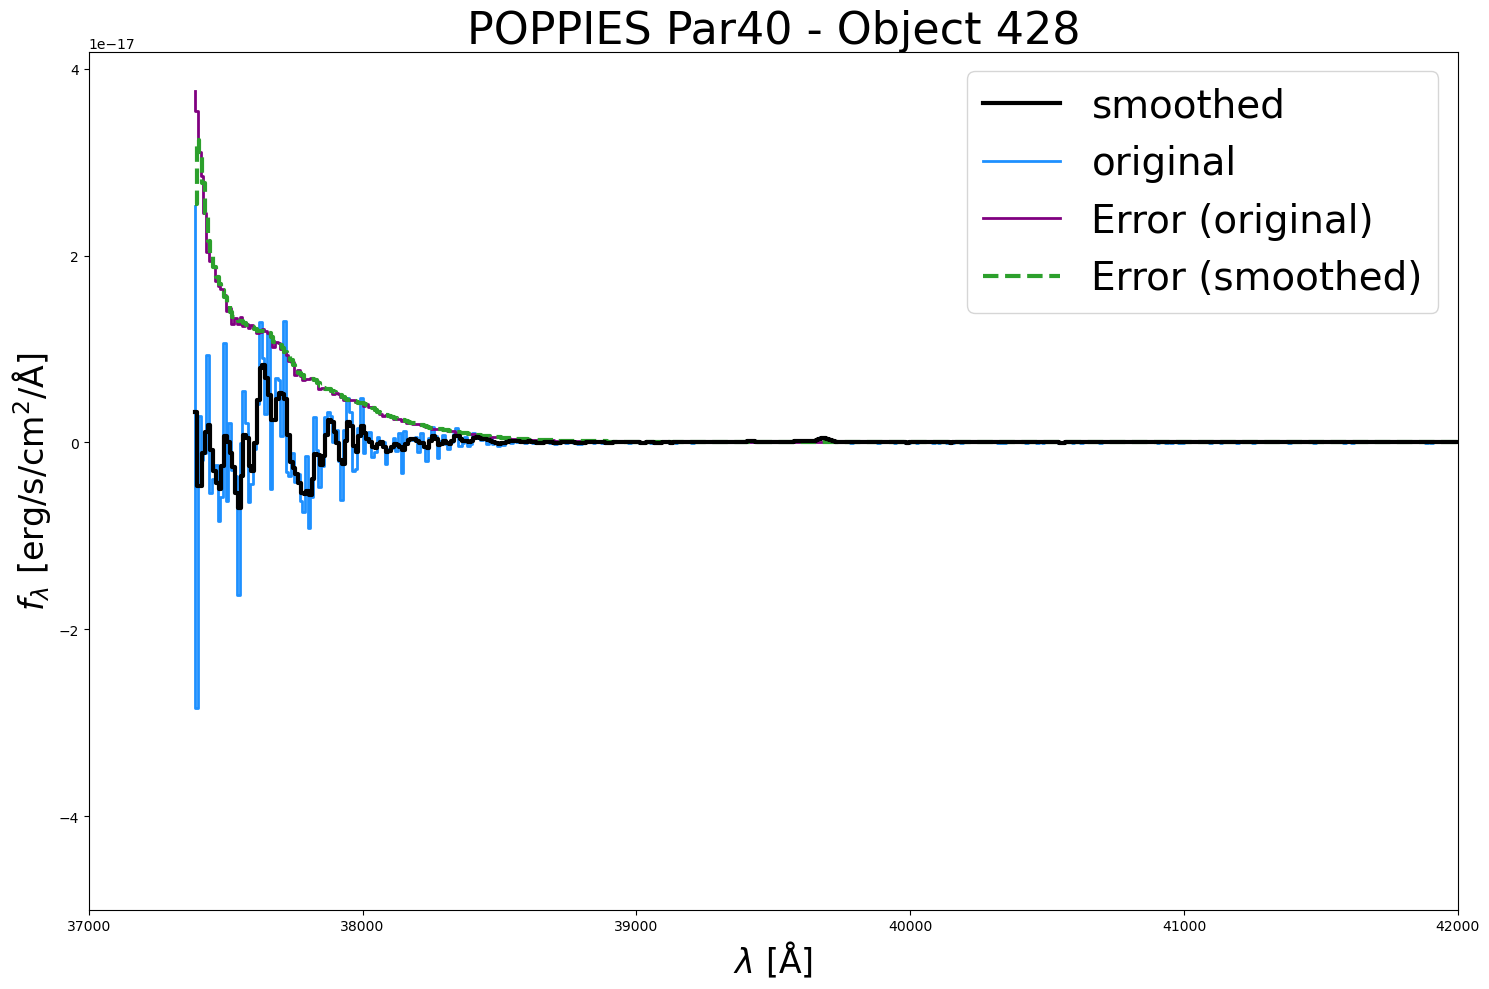

(array([37389.27721977, 37399.27721977, 37409.27721977, ...,
        51419.27721977, 51429.27721977, 51439.27721977]),
 array([ 3.25855695e-18, -4.65479810e-18, -4.66567419e-18, ...,
        -2.20661916e-17, -3.01070120e-17, -2.93946479e-17]),
 array([2.54853335e-17, 3.23832661e-17, 3.11309435e-17, ...,
        1.77878098e-17, 1.86067906e-17, 1.69644634e-17]),
 array([5.81529109e-23, 8.13438021e-23, 8.80974730e-23, ...,
        8.72179868e-23, 8.58109384e-23, 7.66047205e-23]))

In [309]:
## test on some objects
resample_spectra_eg(428,disp_blue=10,disp_red=10,plots=True)

In [79]:
## For use in all the spectra below:

def resample_spectra(specfile, disp_blue=10, disp_red=10, verbose = True, plots=False):

    ''' 
    For a given file
    '''
    # main_dir = main_directory
    # plot_dir = main_dir+'/plots'
    # run_dir = main_directory + 'Data/{}'.format(str(par_names[0])) + '/spec1D/' 

    if (verbose == True):
        print('Resampling POPPIES Spectra for file ', specfile)
    
    # specfile = run_dir + 'A_F444W_GRISMR_{}.V4.fits'.format(str(idx))

    fff = fits.open(specfile)
    
    ext = 1
    
    specdata = Table.read(fff[ext], format='fits')
    # specdata = pd.DataFrame({})

    # print(specdata)
    
    # specdata = asciitable.read(specfile, fill_values=[('--', '-99')])

    ##### get spectrum
    lam_spec = specdata['WAVELENGTH'] * 10000  ## micron to AA
    flam_spec = specdata['OPTFLUX']
    flam_spec_err = specdata['OPTFLUXERR']
    # mask_spec = specdata['Masked']
    cont_spec = specdata['MODELFLUX']    
    contam_spec = specdata['CONTAMFLUX']

    good_inds = np.where((~np.isnan(lam_spec))&(~np.isnan(flam_spec)))[0]

    lamb1 = lam_spec[good_inds] * u.AA
    flux1 = flam_spec[good_inds] * u.Unit('erg cm-2 s-1 AA-1')
    ferr1 = flam_spec_err[good_inds] * u.Unit('erg cm-2 s-1 AA-1')
    cont1 = cont_spec[good_inds] * u.Unit('erg cm-2 s-1 AA-1')
    # mask1 = mask_spec

    # lamb2 = lam_spec[3796:len(lam_spec)] * u.AA
    # flux2 = flam_spec[3796:len(flam_spec)] * u.Unit('erg cm-2 s-1 AA-1')
    # ferr2 = flam_spec_err[3796:len(flam_spec_err)] * u.Unit('erg cm-2 s-1 AA-1')
    # cont2 = cont_spec[3796:len(cont_spec)] * u.Unit('erg cm-2 s-1 AA-1')
    # mask2 = mask_spec[3796:len(mask_spec)]
    
    input_spec = Spectrum1D(spectral_axis=lamb1, flux=flux1)
    input_ferr = Spectrum1D(spectral_axis=lamb1, flux=ferr1)
    input_cont = Spectrum1D(spectral_axis=lamb1, flux=cont1)

    # Smoothed.
    spec1_gsmooth = gaussian_smooth(input_spec, stddev=(disp_blue/disp_red)) # set based on grism and confirm flux conservation.
    ferr1_gsmooth = gaussian_smooth(input_ferr, stddev=(disp_blue/disp_red)) # set based on grism and confirm flux conservation.
    cont1_gsmooth = gaussian_smooth(input_cont, stddev=(disp_blue/disp_red)) # set based on grism and confirm flux conservation.

    # Resampled.
    new_disp_grid = np.arange(lam_spec[good_inds][0], lam_spec[good_inds][-1], 10) * u.AA
    #print('The new grid has length:', len(new_disp_grid))
    fluxcon = FluxConservingResampler()
    new_spec_fluxcon = fluxcon(spec1_gsmooth, new_disp_grid)
    new_ferr_fluxcon = fluxcon(ferr1_gsmooth, new_disp_grid)
    new_cont_fluxcon = fluxcon(cont1_gsmooth, new_disp_grid)
    
    # # Masks.
    # mask_func = interpolate.interp1d(lam_spec, mask_spec, fill_value = -1, bounds_error = False, kind = 'nearest')
    # mask_new = mask_func(new_disp_grid)
    # #print('Mask before resamp:', mask_spec)
    # #print('Mask after resamp:', mask_new)
    # #print('length of new Mask:', len(mask_new))
    # #print('Type:', type(mask_new), type(mask2.value))
    # mask_resamp = np.concatenate((np.array(mask_new), np.array(mask2.value)))
    
    # Replace flux values.
    spec1 = Spectrum1D(spectral_axis=new_spec_fluxcon.spectral_axis, flux=new_spec_fluxcon.flux)
    # spec2 = Spectrum1D(spectral_axis=lamb2, flux=flux2)
    # new_spectral_axis = np.concatenate([spec1.spectral_axis.value, spec2.spectral_axis.to_value(spec1.spectral_axis.unit)]) * spec1.spectral_axis.unit
    new_spectral_axis = spec1.spectral_axis.value * spec1.spectral_axis.unit

    resampler = LinearInterpolatedResampler(extrapolation_treatment='zero_fill')
    new_spec1 = resampler(spec1, new_spectral_axis)
    # new_spec2 = resampler(spec2, new_spectral_axis)
    # final_spec = new_spec1 + new_spec2
    final_spec = new_spec1

    # Replace ferr values.
    ferr1 = Spectrum1D(spectral_axis=new_ferr_fluxcon.spectral_axis, flux=new_ferr_fluxcon.flux)
    # ferr2 = Spectrum1D(spectral_axis=lamb2, flux=ferr2)
    # new_ferr_axis = np.concatenate([ferr1.spectral_axis.value, ferr2.spectral_axis.to_value(ferr1.spectral_axis.unit)]) * ferr1.spectral_axis.unit
    new_ferr_axis = ferr1.spectral_axis.value * ferr1.spectral_axis.unit

    resampler = LinearInterpolatedResampler(extrapolation_treatment='zero_fill')
    new_ferr1 = resampler(ferr1, new_spectral_axis)
    
    # new_ferr2 = resampler(ferr2, new_spectral_axis)
    final_ferr = new_ferr1 

    
    # Replace cont values.
    cont1 = Spectrum1D(spectral_axis=new_cont_fluxcon.spectral_axis, flux=new_cont_fluxcon.flux)
    # cont2 = Spectrum1D(spectral_axis=lamb2, flux=cont2)
    new_cont_axis = cont1.spectral_axis.value * cont1.spectral_axis.unit
    resampler = LinearInterpolatedResampler(extrapolation_treatment='zero_fill')
    new_cont1 = resampler(cont1, new_spectral_axis)
    # new_cont2 = resampler(cont2, new_spectral_axis)
    final_cont = new_cont1


    if plots == True:

        
        # Plot the original and resampled.
        f, ax = plt.subplots(figsize=(15,10))
        ax.step(final_spec.spectral_axis, final_spec.flux, where='mid', label = 'smoothed', c='k', lw=3)
        # ax.step(spec1.spectral_axis, spec1.flux, ls='--', where='mid', lw=1) 
        # ax.step(spec2.spectral_axis, spec2.flux, ls='--', where='mid', lw=1)
        ax.step(input_spec.spectral_axis, input_spec.flux, label='original', lw=2, color='dodgerblue', zorder=-3) # original
        ax.set_xlim([37000,40000])
        # ax.set_ylim([-2.0e-19, 8.0e-19])
        ax.step(lam_spec, flam_spec_err, label='Error (original)', color='purple', lw=2, zorder=-2)
        ax.step(final_ferr.spectral_axis, final_ferr.flux, ls='--', where='mid', label='Error (smoothed)', c='C2', lw=3, zorder=-2)
        #ax.step(lam_spec, cont_spec, label='Continuum (original)', color='gold', zorder=-2)
        #ax.step(final_cont.spectral_axis, final_cont.flux, ls='--', where='mid', c='C2', lw=2, zorder=-2)    
        #matplotlib.pyplot.show()
        plt.xlabel(r'$\lambda~[\mathrm{\AA}]$',fontsize=24)
        plt.ylabel(r'$f_{\lambda}~[\mathrm{erg/s/cm^2/\AA}]$',fontsize=24)
        plt.title(r'POPPIES {} - Object {}'.format(str(par_names[0]),str(idx)),fontsize=32)
        plt.legend(loc='best',fontsize=28)
        plt.tight_layout() 

        plt.savefig(main_directory+'Plots/{}_smooth.pdf'.format(str(specfile)),bbox_inches='tight',dpi=200)
        
        plt.show()
    
    
    return final_spec.spectral_axis.value, final_spec.flux.value, final_ferr.flux.value, final_cont.flux.value


2. Now create 1D spectral files

### Create 1D spectral files

In [87]:
# flag for creating the output files regardless of whehter they already exist
# True = create new files
# False = create new files only if they do not exist 
create_files_anyway = True

In [97]:
### OLD Way -- without smoothing

par_names = ['Par40']

for i in par_names:
    
    # try:os.mkdir(data_directory)
    # except:print('I did not make your directory')
    # try:
    #     os.chdir(data_directory)
    #     os.mkdir('Spectra')
    # except:print('I did not make your directory')

    dir = main_directory + 'Data/' + str(i) + '/spec1D/'

    dir0 = main_directory + 'Data/' + str(i) + '/'
    
    os.chdir(dir)
    print('moving to:', dir)
    
    files = sorted(glob.glob('*.fits'))

    # Check if converted files already exist. If they do not, carry on with the conversion. 
    # Otherwise, this step can be skipped. 
    # Here, I just check if there are more converted files than objects (there can be 1-3 per object)
    # depending on how many filters are available for each object
    already_converted_files = glob.glob(data_directory + 'Spectra/*.dat')
    if len(files) >= len(already_converted_files) or create_files_anyway == True:
        print(len(already_converted_files))
        print(len(files))
    
        print('\nThere are ' + str(len(files)) + ' POPPIES files to convert.\n')
        
        for f in files:
            os.chdir(dir)
            #os.chdir(spec1D_directory+par_names[0]+'/')
            fff = fits.open(f)
            print(fff.info())

            # print(os.getcwd())
            
            # for ext in range(1, len(fff)):

            ext = 1
            
            tb = Table.read(fff[ext], format='fits').to_pandas()
            t_out = pd.DataFrame({})

            
            t_out['wave'] = tb['WAVELENGTH'] * 10000 #micron to A
            
            # t_out['flux'] = tb['FLUX']
            # t_out['error'] = tb['FLUXERR']

            t_out['flux'] = tb['OPTFLUX']
            t_out['error'] = tb['OPTFLUXERR']

            t_out['contam'] = tb['CONTAMFLUX']
            t_out['zeroth'] = np.zeros(len(tb['WAVELENGTH'])).astype('int')
            t_out = Table.from_pandas(t_out)
            t_out = t_out.filled(0.0) # Replace nans with zeros
            # Spectra dispersed beyond the chip have zero fluxes that must be replaced to prevent crashes in fitting.
            t_out['flux'][np.where(t_out['flux'] == 0.0)] = np.median(t_out['flux'][np.where(t_out['flux'] != 0.0)])
            t_out['error'][np.where(t_out['error'] == 0.0)]=np.median(t_out['error'][np.where(t_out['error'] != 0.0)])

            print('saving to '+ dir0 + 'Spectra' )
            os.chdir(dir0 + 'Spectra' )

            # Write out the updated files.
            # if fff[ext].header['EXTNAME'] == 'F200W':

            print('base ',os.path.basename(f))

            # _indexes_ = [i for i in range(len(fff[ext].data))]
            
            # try:_indexes_ = [i for i in _indexes_ if t_out['wave'][i] > max(Table.read(fff[ext-1])['wave']) ]
            # except:pass
            t_out.write(os.path.basename(f).replace('.fits', '_1D.dat'), 
                    format='ascii.fixed_width_two_line', overwrite=True)      


                                       
            # # Write out the updated files.
            # if fff[ext].header['EXTNAME'] == 'F150W':
            #     #t_out.write(os.path.basename(f).replace('1D.fits', 'G150_1D_uncomb.dat'), 
            #     t_out.write(os.path.basename(f).replace('1D.fits', 'G150_1D.dat'), 
            #             format='ascii.fixed_width_two_line', overwrite=True)
                
            # elif fff[ext].header['EXTNAME'] == 'F115W':
            #     t_out.write(os.path.basename(f).replace('1D.fits', 'G115_1D.dat'), 
            #             format='ascii.fixed_width_two_line', overwrite=True)


                                       
        # # THE BELOW IS NO LONGER NEEDED. 
    
        # # Now that the .dat files have been created/updated, need to combine the F200W with the F150W
        # # # since the next code expects only 2 grism filters.
        # # os.chdir(data_directory + '/Spectra' )

        # # target_dir = data_directory + 'Spectra'
        # # F200s = glob.glob(target_dir+'/*G200_1D.dat')
        
        # # for i in range(len(F200s)):
        #     # F150s = F200s[i].split('G200_1D.dat')[0]+str('G150_1D_uncomb.dat')
        #     # tb_200 = Table.read(F200s[i], format='ascii')
        #     # if os.path.exists(F150s):
        #         # tb_150 = Table.read(F150s, format='ascii')
                    
        #     # tout = vstack([tb_150, tb_200])
        #     # print(os.path.basename(F150s).replace('G150_1D_uncomb.dat', 'G150_1D.dat'))
                
        #     # tout.write(os.path.basename(F150s).replace('G150_1D_uncomb.dat', 'G150_1D.dat'), 
        #                     # format='ascii.fixed_width_two_line', overwrite=True)


    else: print('It appears the .dat files were already created for this field. Skipping this step.')
    


moving to: /Users/fhasan/Desktop/Research_STScI/POPPIES/Data/Par40/spec1D/
0
2549

There are 2549 POPPIES files to convert.

Filename: A_F444W_GRISMC_1.V4.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     34   1440R x 13C   [D, D, D, D, D, D, D, D, D, D, D, D, D]   
  2  2D_COUNT      1 ImageHDU        20   (1440, 200)   float64   
  3  2D_ERR        1 ImageHDU        20   (1440, 200)   float64   
  4  2D_TCOUNT     1 ImageHDU        20   (1440, 200)   float64   
  5  2D_CCOUNT     1 ImageHDU        20   (1440, 200)   float64   
  6  2D_MCOUNT     1 ImageHDU        20   (1440, 200)   float64   
  7  2D_WAVE       1 ImageHDU        20   (1440, 200)   float64   
None
saving to /Users/fhasan/Desktop/Research_STScI/POPPIES/Data/Par40/Spectra
base  A_F444W_GRISMC_1.V4.fits
Filename: A_F444W_GRISMC_10.V4.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY      

In [83]:
### New way - with smoothing

par_names = ['Par40']

for i in par_names:
    
    # try:os.mkdir(data_directory)
    # except:print('I did not make your directory')
    # try:
    #     os.chdir(data_directory)
    #     os.mkdir('Spectra')
    # except:print('I did not make your directory')

    dir = main_directory + 'Data/' + str(i) + '/spec1D/'

    dir0 = main_directory + 'Data/' + str(i) + '/'
    
    os.chdir(dir)
    print('moving to:', dir)
    
    files = sorted(glob.glob('*.fits'))

    # Check if converted files already exist. If they do not, carry on with the conversion. 
    # Otherwise, this step can be skipped. 
    # Here, I just check if there are more converted files than objects (there can be 1-3 per object)
    # depending on how many filters are available for each object
    already_converted_files = glob.glob(data_directory + 'Spectra/*.dat')
    
    if len(files) >= len(already_converted_files) or create_files_anyway == True:
        print(len(already_converted_files))
        print(len(files))
    
        print('\nThere are ' + str(len(files)) + ' POPPIES files to convert.\n')
        
        for f in files:
            os.chdir(dir)
            #os.chdir(spec1D_directory+par_names[0]+'/')

            print(f)

            t_out = pd.DataFrame({})

            wave, flux, err, cont = resample_spectra(f, disp_blue=10, disp_red=10)
            
            # fff = fits.open(f)
            # print(fff.info())

            # print(os.getcwd())
            
            # for ext in range(1, len(fff)):

            # ext = 1
            
            # tb = Table.read(fff[ext], format='fits').to_pandas()
            # t_out = pd.DataFrame({})
            
            t_out['wave'] = wave
            
            t_out['flux'] = flux
            t_out['error'] = err

            t_out['contam'] = cont

            t_out['zeroth'] = np.zeros(len(wave)).astype('int')
            t_out = Table.from_pandas(t_out)
            
            t_out = t_out.filled(0.0) # Replace nans with zeros
            
            # Spectra dispersed beyond the chip have zero fluxes that must be replaced to prevent crashes in fitting.
            t_out['flux'][np.where(t_out['flux'] == 0.0)] = np.median(t_out['flux'][np.where(t_out['flux'] != 0.0)])
            t_out['error'][np.where(t_out['error'] == 0.0)]=np.median(t_out['error'][np.where(t_out['error'] != 0.0)])

            print('saving to '+ dir0 + 'Spectra' )
            os.chdir(dir0 + 'Spectra' )

            # Write out the updated files.
            # if fff[ext].header['EXTNAME'] == 'F200W':

            print('base ',os.path.basename(f))

            # _indexes_ = [i for i in range(len(fff[ext].data))]
            
            # try:_indexes_ = [i for i in _indexes_ if t_out['wave'][i] > max(Table.read(fff[ext-1])['wave']) ]
            # except:pass
            t_out.write(os.path.basename(f).replace('.fits', '_1D.dat'), 
                    format='ascii.fixed_width_two_line', overwrite=True)      
                                    

    else: print('It appears the .dat files were already created for this field. Skipping this step.')
    


moving to: /Users/fhasan/Desktop/Research_STScI/POPPIES/Data/Par40/spec1D/
0
2549

There are 2549 POPPIES files to convert.

A_F444W_GRISMC_1.V4.fits
Resampling POPPIES Spectra for file  A_F444W_GRISMC_1.V4.fits
saving to /Users/fhasan/Desktop/Research_STScI/POPPIES/Data/Par40/Spectra
base  A_F444W_GRISMC_1.V4.fits
A_F444W_GRISMC_10.V4.fits
Resampling POPPIES Spectra for file  A_F444W_GRISMC_10.V4.fits
saving to /Users/fhasan/Desktop/Research_STScI/POPPIES/Data/Par40/Spectra
base  A_F444W_GRISMC_10.V4.fits
A_F444W_GRISMC_100.V4.fits
Resampling POPPIES Spectra for file  A_F444W_GRISMC_100.V4.fits
saving to /Users/fhasan/Desktop/Research_STScI/POPPIES/Data/Par40/Spectra
base  A_F444W_GRISMC_100.V4.fits
A_F444W_GRISMC_101.V4.fits
Resampling POPPIES Spectra for file  A_F444W_GRISMC_101.V4.fits
saving to /Users/fhasan/Desktop/Research_STScI/POPPIES/Data/Par40/Spectra
base  A_F444W_GRISMC_101.V4.fits
A_F444W_GRISMC_102.V4.fits
Resampling POPPIES Spectra for file  A_F444W_GRISMC_102.V4.fits
s

In [267]:
os.getcwd()

'/Users/fhasan/Desktop/Research_STScI/POPPIES/Data/Par40/Spectra'

In [307]:
np.linspace(38800,50840,16)

array([38800.        , 39602.66666667, 40405.33333333, 41208.        ,
       42010.66666667, 42813.33333333, 43616.        , 44418.66666667,
       45221.33333333, 46024.        , 46826.66666667, 47629.33333333,
       48432.        , 49234.66666667, 50037.33333333, 50840.        ])

In [341]:
filename = 'A_F444W_GRISMC_6.V4_1D.dat'

filename.split('GRISM')[1].split('_')[1].split('.')[0]

'6'

#### Testing - temp files

In [390]:
# f4 = fits.open(research_directory+'PASSAGE/Data/Par28/DATA/'+'Par28_f150w-gr150r_drz_sci.fits') ## open PASSAGE FITS file for reference

# g = fits.open(data_directory+'A/'+'jw05398040_A_F444W_i2d.fits')

temp_passage = ascii.read(research_directory+'PASSAGE/Output/linelist/temp')

temp_poppies = ascii.read(research_directory+'POPPIES/Output/linelist/temp')


In [392]:
temp_poppies

<Table length=9>
 col1  col2  col3        col4         col5        col6       
int64  str5 int64      float64       int64      float64      
----- ----- ----- ------------------ ----- ------------------
   40 F444W   100 50201.965400150846     5 17.341211005028445
   40 F444W    19  43182.73680550711     4 17.445138876195298
   40 F444W   214 39823.157457595174     3 11.803117148844086
   40 F444W   245  46242.58041381836     5  15.45502462540146
   40 F444W   431  47201.16436481476     3 103.10581456123302
   40 F444W    55  38596.64887189865     4  12.63685744238418
   40 F444W    92  43230.78207347704     5 18.627762053828324
   40 F444W   428  39680.42254447937     3  8.390081487611916
   40 F444W    92 43241.744659565105     4  20.56753105025703

In [376]:
os.getcwd()

'/Users/fhasan/Desktop/Research_STScI/POPPIES/Data/Par40/Spectra'

## Create 1D spectroscopic file for the R and C orientations  <a class="anchor" id="orientations"><a>
[Table of Contents](#tag0)

In [86]:
photcat_file = glob.glob(data_directory+'DATA/DIRECT_GRISM/*_photcat.fits')
photcat = Table.read(photcat_file[0])

speccat_file = glob.glob(data_directory+'DATA/DIRECT_GRISM/*_speccat.fits')
speccat =  Table.read(speccat_file[0])


In [7]:
def make_table(tb):
    t_out = pd.DataFrame({})
    t_out['wave'] = tb['wave']
    t_out['flux'] = tb['flux']/tb['flat']
    t_out['error'] = tb['err']/tb['flat']
    t_out['contam'] = tb['contam']/tb['flat']
    t_out['zeroth'] = np.zeros(len(tb['wave'])).astype('int')
    t_out = Table.from_pandas(t_out)
    t_out = t_out.filled(0.0) # Replace nans with zeros
    # Spectra dispersed beyond the chip have zero fluxes that must be replaced to prevent crashes in fitting.
    t_out['flux'][np.where(t_out['flux'] == 0.0)] = np.median(t_out['flux'][np.where(t_out['flux'] != 0.0)])
    t_out['error'][np.where(t_out['error'] == 0.0)]=np.median(t_out['error'][np.where(t_out['error'] != 0.0)])

    return t_out

In [87]:


for i in par_names:
    beam_files = glob.glob(data_directory + 'beams/*.beams.fits')
    os.chdir(data_directory + 'Spectra/')
    start = time()

    for j in beam_files:
        id = int(j.split('/')[-1].split('_')[1].split('.')[0])
        z = speccat['redshift'][[k for k in range(len(speccat)) if speccat['id'][k] == id]]

        mb = multifit.MultiBeam(j, fcontam=0.1, sys_err=0.02,
                        min_sens=0.05, MW_EBV=-1, group_name='', verbose=False)

        Cgrism_beams = [mb.beams[k] for k in range(len(mb.beams)) if  mb.beams[k].grism.filter == 'GR150C']
        Rgrism_beams = [mb.beams[k] for k in range(len(mb.beams)) if  mb.beams[k].grism.filter == 'GR150R']
        
        if len(Cgrism_beams) > 0:
            mb_C = multifit.MultiBeam(beams=Cgrism_beams, fcontam=0.1, sys_err=0.02, 
                        min_sens=0.05, MW_EBV=-1, group_name='')
            
            # this catches cases where spectrum contains only zeros (very rare)
            # The fit will crash in such cases
            try:
                tfitC = mb_C.template_at_z(z, fitter='bounded')
                keys_C = mb_C.oned_spectrum(tfit=tfitC, bin=1).keys()
            except: keys_C = mb_C.oned_spectrum(bin=1).keys()
            
            for c in keys_C:
                t_out = make_table(mb_C.oned_spectrum(tfit=tfitC, bin=1)[c])
                t_out.write(os.path.basename(j).replace('beams.fits', c+'_1D_C.dat'), 
                            format='ascii.fixed_width_two_line', overwrite=True)

        if len(Rgrism_beams) > 0:
            mb_R = multifit.MultiBeam(beams=Rgrism_beams, fcontam=0.1, sys_err=0.02, 
                        min_sens=0.05, MW_EBV=-1, group_name='')

            # this catches cases where spectrum contains only zeros (very rare)
            # The fit will crash in such cases
            try:
                tfitR = mb_R.template_at_z(z, fitter='bounded')
                keys_R = mb_R.oned_spectrum(tfit=tfitR, bin=1).keys()
            except: keys_R = mb_R.oned_spectrum(bin=1).keys()
                
            for r in keys_R:
                t_out = make_table(mb_R.oned_spectrum(tfit=tfitR, bin=1)[r])
                t_out.write(os.path.basename(j).replace('beams.fits', r+'_1D_R.dat'), 
                            format='ascii.fixed_width_two_line', overwrite=True)


        end = time()
        print(end - start)




 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
4.974880933761597
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
10.830098152160645
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1

2024-07-31 07:38:23,553 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 07:38:23,554 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 07:38:23,554 - stpipe - WARNING - 
2024-07-31 07:38:23,620 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 07:38:23,628 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 07:38:23,633 - stpipe - WARNING - 
2024-07-31 07:38:25,063 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 07:38:25,073 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 07:38:25,109 - stpipe - WARNING - 
2024-07-31 07:38:25,208 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

139.6674680709839
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
146.28913593292236
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
152.48337292671204
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 07:44:22,548 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 07:44:22,556 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 07:44:22,557 - stpipe - WARNING - 


496.9595251083374
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5


2024-07-31 07:44:27,060 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 07:44:27,080 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 07:44:27,112 - stpipe - WARNING - 
2024-07-31 07:44:27,223 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 07:44:27,223 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 07:44:27,223 - stpipe - WARNING - 
2024-07-31 07:44:28,719 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 07:44:28,742 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 07:44:28,774 - stpipe - WARNING - 
2024-07-31 07:44:28,854 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

503.3171079158783
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
509.5767111778259
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
515.6108999252319
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by 

2024-07-31 07:45:16,818 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 07:45:16,824 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 07:45:16,827 - stpipe - WARNING - 
2024-07-31 07:45:18,450 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 07:45:18,451 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 07:45:18,453 - stpipe - WARNING - 


553.0231039524078
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
559.6211049556732
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
566.0926179885864
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by 

2024-07-31 07:57:49,881 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 07:57:49,891 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 07:57:49,896 - stpipe - WARNING - 
2024-07-31 07:57:51,336 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 07:57:51,348 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 07:57:51,365 - stpipe - WARNING - 


1305.8145229816437
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
1312.74671792984
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
1318.766489982605
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by 

2024-07-31 07:58:55,362 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 07:58:55,366 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 07:58:55,368 - stpipe - WARNING - 
2024-07-31 07:58:56,861 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 07:58:56,866 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 07:58:56,867 - stpipe - WARNING - 


1371.3280138969421
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
1378.2959830760956
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
1385.0494377613068
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) 

2024-07-31 07:59:14,955 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 07:59:14,969 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 07:59:14,971 - stpipe - WARNING - 
2024-07-31 07:59:15,071 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 07:59:15,072 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 07:59:15,072 - stpipe - WARNING - 
2024-07-31 07:59:16,390 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 07:59:16,393 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 07:59:16,393 - stpipe - WARNING - 
2024-07-31 07:59:16,537 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

1390.9917538166046
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
1397.386463880539
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
1403.8185682296753
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 07:59:47,361 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 07:59:47,378 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 07:59:47,394 - stpipe - WARNING - 
2024-07-31 07:59:47,495 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 07:59:47,495 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 07:59:47,496 - stpipe - WARNING - 
2024-07-31 07:59:48,751 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 07:59:48,751 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 07:59:48,753 - stpipe - WARNING - 
2024-07-31 07:59:48,872 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

1423.3218159675598
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
1429.7411680221558
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
1435.681293964386
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 08:00:05,818 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:00:05,852 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:00:05,857 - stpipe - WARNING - 
2024-07-31 08:00:05,960 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:00:05,960 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:00:05,961 - stpipe - WARNING - 
2024-07-31 08:00:07,716 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:00:07,717 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:00:07,718 - stpipe - WARNING - 
2024-07-31 08:00:07,785 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

1442.256383895874
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
1447.791846036911
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
1453.9018740653992
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by

2024-07-31 08:02:27,975 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:02:27,976 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:02:27,977 - stpipe - WARNING - 


1584.25381398201
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
1589.326369047165
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
1596.431165933609
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by a

2024-07-31 08:05:24,161 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:05:24,161 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:05:24,162 - stpipe - WARNING - 
2024-07-31 08:05:24,263 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:05:24,264 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:05:24,266 - stpipe - WARNING - 
2024-07-31 08:05:25,764 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:05:25,765 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:05:25,774 - stpipe - WARNING - 
2024-07-31 08:05:25,883 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

1760.338809967041
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
1767.2444899082184
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
1773.6140520572662
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 08:05:56,587 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:05:56,594 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:05:56,594 - stpipe - WARNING - 


Except: covar!
1793.4136590957642
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
1799.0481231212616
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
1805.164577960968
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 

2024-07-31 08:08:32,391 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:08:32,393 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:08:32,394 - stpipe - WARNING - 


1948.3624968528748
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
1955.7969629764557
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
1961.7837591171265
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) 

2024-07-31 08:13:37,419 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:13:37,422 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:13:37,423 - stpipe - WARNING - 
2024-07-31 08:13:37,489 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:13:37,490 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:13:37,494 - stpipe - WARNING - 
2024-07-31 08:13:39,732 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:13:39,740 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:13:39,752 - stpipe - WARNING - 
2024-07-31 08:13:39,843 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

2254.308065891266
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
2261.641874074936
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
2269.572480916977
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by 

2024-07-31 08:17:11,473 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:17:11,483 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:17:11,485 - stpipe - WARNING - 
2024-07-31 08:17:12,852 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:17:12,852 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:17:12,852 - stpipe - WARNING - 


2467.3055720329285
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
2472.446462869644
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
2478.5536890029907
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 08:17:42,428 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:17:42,429 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:17:42,431 - stpipe - WARNING - 
2024-07-31 08:17:42,525 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:17:42,526 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:17:42,526 - stpipe - WARNING - 
2024-07-31 08:17:44,166 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:17:44,167 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:17:44,167 - stpipe - WARNING - 
2024-07-31 08:17:44,271 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

2498.7702219486237
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
2504.4534981250763
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
2510.37858915329
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by

2024-07-31 08:23:04,263 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:23:04,293 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:23:04,293 - stpipe - WARNING - 
2024-07-31 08:23:05,854 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:23:05,869 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:23:05,870 - stpipe - WARNING - 


2820.4165029525757
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5


2024-07-31 08:23:12,128 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:23:12,135 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:23:12,146 - stpipe - WARNING - 


2826.7215569019318
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
2832.967131137848
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
2838.0247650146484
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 08:23:29,498 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:23:29,501 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:23:29,502 - stpipe - WARNING - 


2844.0654261112213
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
2851.635615825653
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
2857.171947956085
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by

2024-07-31 08:24:49,353 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:24:49,363 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:24:49,373 - stpipe - WARNING - 


2925.147248029709
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
2931.2420439720154
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
2937.633203983307
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by

2024-07-31 08:31:14,791 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:31:14,799 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:31:14,800 - stpipe - WARNING - 


3310.7755029201508
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
3316.5649230480194
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
3322.311511039734
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 08:33:13,296 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:33:13,297 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:33:13,299 - stpipe - WARNING - 
2024-07-31 08:33:13,383 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:33:13,384 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:33:13,385 - stpipe - WARNING - 
2024-07-31 08:33:13,457 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:33:13,458 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:33:13,458 - stpipe - WARNING - 
2024-07-31 08:33:15,169 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

3429.7710399627686
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
3436.3448309898376
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5


2024-07-31 08:33:26,417 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:33:26,424 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:33:26,425 - stpipe - WARNING - 
2024-07-31 08:33:27,925 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:33:27,926 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:33:27,926 - stpipe - WARNING - 


3442.3730239868164
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
Except: covar!
3447.5573949813843
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
3453.806298017502
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 

2024-07-31 08:36:13,185 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:36:13,227 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:36:13,247 - stpipe - WARNING - 


3607.8014850616455
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
3614.1884231567383
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
3621.4081540107727
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) 

2024-07-31 08:38:07,112 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:38:07,121 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:38:07,173 - stpipe - WARNING - 
2024-07-31 08:38:08,772 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:38:08,775 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:38:08,777 - stpipe - WARNING - 


3723.2364070415497
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
3728.5135259628296
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
3734.20011305809
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by

2024-07-31 08:38:48,989 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:38:48,994 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:38:48,996 - stpipe - WARNING - 


Except: covar!
3766.1772179603577
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
3771.9632489681244
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
3777.197825908661
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 

2024-07-31 08:39:13,736 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:39:13,736 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:39:13,737 - stpipe - WARNING - 
2024-07-31 08:39:15,367 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:39:15,374 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:39:15,377 - stpipe - WARNING - 


3789.909677028656
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
3795.73700094223
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
3802.373414039612
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by a

2024-07-31 08:52:18,260 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:52:18,266 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:52:18,287 - stpipe - WARNING - 
2024-07-31 08:52:19,960 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:52:19,966 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:52:19,966 - stpipe - WARNING - 


4574.513471841812
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
4580.647216081619
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
4586.9416680336
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an

2024-07-31 08:53:28,140 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:53:28,146 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:53:28,149 - stpipe - WARNING - 
2024-07-31 08:53:28,239 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:53:28,281 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:53:28,285 - stpipe - WARNING - 
2024-07-31 08:53:30,182 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:53:30,193 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:53:30,199 - stpipe - WARNING - 
2024-07-31 08:53:30,315 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

4644.770696878433
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
4653.82147192955
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
4660.063127040863
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by a

2024-07-31 08:55:14,739 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:55:14,775 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:55:14,785 - stpipe - WARNING - 
2024-07-31 08:55:14,852 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:55:14,852 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:55:14,852 - stpipe - WARNING - 
2024-07-31 08:55:16,395 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 08:55:16,398 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 08:55:16,398 - stpipe - WARNING - 
2024-07-31 08:55:16,498 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

4750.957720994949
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
4758.031356096268
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
4764.996541976929
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by 

2024-07-31 09:03:43,525 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:03:43,528 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:03:43,530 - stpipe - WARNING - 
2024-07-31 09:03:43,599 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:03:43,615 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:03:43,616 - stpipe - WARNING - 
2024-07-31 09:03:43,783 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:03:43,784 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:03:43,784 - stpipe - WARNING - 
2024-07-31 09:03:44,994 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

5259.575371026993
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
5264.550301074982
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5


2024-07-31 09:03:54,396 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:03:54,404 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:03:54,406 - stpipe - WARNING - 
2024-07-31 09:03:54,537 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:03:54,542 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:03:54,546 - stpipe - WARNING - 
2024-07-31 09:03:56,304 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:03:56,309 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:03:56,310 - stpipe - WARNING - 
2024-07-31 09:03:56,435 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

5270.88516497612
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
5277.754086971283
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
5286.102266073227
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by a

2024-07-31 09:04:22,551 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:04:22,553 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:04:22,554 - stpipe - WARNING - 
2024-07-31 09:04:22,629 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:04:22,644 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:04:22,647 - stpipe - WARNING - 
2024-07-31 09:04:24,423 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:04:24,424 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:04:24,425 - stpipe - WARNING - 
2024-07-31 09:04:24,505 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

5298.965266942978
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
5305.079795837402
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
5312.375021934509
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by 

2024-07-31 09:07:16,743 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:07:16,744 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:07:16,746 - stpipe - WARNING - 
2024-07-31 09:07:18,689 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:07:18,712 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:07:18,731 - stpipe - WARNING - 
2024-07-31 09:07:18,819 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:07:18,820 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:07:18,820 - stpipe - WARNING - 


5473.270881891251
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
5479.808475017548
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
5486.496279001236
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by 

2024-07-31 09:08:20,320 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:08:20,326 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:08:20,329 - stpipe - WARNING - 
2024-07-31 09:08:20,407 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:08:20,408 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:08:20,408 - stpipe - WARNING - 


5534.864159822464
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
5541.656330823898
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
5548.5645179748535
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by

2024-07-31 09:11:53,175 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:11:53,177 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:11:53,178 - stpipe - WARNING - 


5749.325481891632
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
5757.416460990906
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
5764.012168169022
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by 

2024-07-31 09:12:56,458 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:12:56,462 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:12:56,463 - stpipe - WARNING - 


5810.861418008804
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
5817.447478055954
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
5823.497012853622
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by 

2024-07-31 09:13:25,713 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:13:25,715 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:13:25,716 - stpipe - WARNING - 
2024-07-31 09:13:27,718 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:13:27,733 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:13:27,737 - stpipe - WARNING - 


5842.273832082748
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
5848.922493219376
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
5855.436820983887
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by 

2024-07-31 09:16:07,546 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:16:07,563 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:16:07,566 - stpipe - WARNING - 
2024-07-31 09:16:07,635 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:16:07,636 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:16:07,636 - stpipe - WARNING - 
2024-07-31 09:16:09,390 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:16:09,391 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:16:09,392 - stpipe - WARNING - 
2024-07-31 09:16:09,485 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

6003.940948963165
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
6009.9283838272095
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
6017.1852951049805
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 09:16:27,939 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:16:27,940 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:16:27,940 - stpipe - WARNING - 


6024.361856937408
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
6030.812605142593
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
6036.609487056732
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by 

2024-07-31 09:16:57,255 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:16:57,268 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:16:57,311 - stpipe - WARNING - 
2024-07-31 09:16:57,358 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:16:57,359 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:16:57,359 - stpipe - WARNING - 
2024-07-31 09:16:59,461 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:16:59,464 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:16:59,464 - stpipe - WARNING - 


6053.916472911835
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
6059.6466109752655
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
6065.742312192917
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by

2024-07-31 09:17:55,615 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:17:55,620 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:17:55,620 - stpipe - WARNING - 


6111.887455940247
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
6117.834286928177
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
6125.444052934647
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by 

2024-07-31 09:21:02,431 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:21:02,462 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:21:02,480 - stpipe - WARNING - 
2024-07-31 09:21:04,247 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:21:04,259 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:21:04,261 - stpipe - WARNING - 


6298.926180124283
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
6305.128828048706
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
6309.785068035126
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by 

2024-07-31 09:23:37,593 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:23:37,594 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:23:37,595 - stpipe - WARNING - 


6453.5786101818085
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
6460.777276992798
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
6467.822461843491
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by

2024-07-31 09:26:16,397 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:26:16,401 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:26:16,403 - stpipe - WARNING - 
2024-07-31 09:26:16,472 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:26:16,472 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:26:16,473 - stpipe - WARNING - 
2024-07-31 09:26:18,256 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:26:18,263 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:26:18,280 - stpipe - WARNING - 
2024-07-31 09:26:18,387 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

6612.849061965942
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
6619.458558797836
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
6627.5059950351715
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by

2024-07-31 09:29:36,044 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:29:36,054 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:29:36,086 - stpipe - WARNING - 
2024-07-31 09:29:36,185 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:29:36,185 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:29:36,186 - stpipe - WARNING - 
2024-07-31 09:29:38,032 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:29:38,051 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:29:38,073 - stpipe - WARNING - 
2024-07-31 09:29:38,169 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

6812.62214589119
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
6818.799795150757
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
6825.195083856583
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by a

2024-07-31 09:30:30,814 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:30:30,837 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:30:30,865 - stpipe - WARNING - 
2024-07-31 09:30:30,967 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:30:30,967 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:30:30,967 - stpipe - WARNING - 
2024-07-31 09:30:32,169 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:30:32,195 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:30:32,216 - stpipe - WARNING - 
2024-07-31 09:30:32,298 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

6866.75616812706
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
6873.399193048477
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
6879.958748102188
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by a

2024-07-31 09:35:41,647 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:35:41,654 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:35:41,672 - stpipe - WARNING - 
2024-07-31 09:35:43,508 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:35:43,513 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:35:43,516 - stpipe - WARNING - 


7178.044162988663
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
7184.8102169036865
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
7190.927718162537
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by

2024-07-31 09:37:25,252 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:37:25,269 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:37:25,338 - stpipe - WARNING - 
2024-07-31 09:37:25,418 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:37:25,419 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:37:25,419 - stpipe - WARNING - 
2024-07-31 09:37:26,914 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:37:26,937 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:37:26,941 - stpipe - WARNING - 
2024-07-31 09:37:27,032 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

7281.488992929459
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
7288.139013051987
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
7294.658999919891
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by 

2024-07-31 09:52:04,821 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:52:04,834 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:52:04,865 - stpipe - WARNING - 


8160.842484951019
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
8167.250810146332
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
8173.739688158035
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by 

2024-07-31 09:52:30,398 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:52:30,404 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:52:30,406 - stpipe - WARNING - 
2024-07-31 09:52:31,666 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:52:31,683 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:52:31,686 - stpipe - WARNING - 


8186.252531051636
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
8192.45762705803
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
8198.380756855011
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by a

2024-07-31 09:54:23,727 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:54:23,737 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:54:23,761 - stpipe - WARNING - 
2024-07-31 09:54:23,849 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:54:23,850 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:54:23,856 - stpipe - WARNING - 
2024-07-31 09:54:23,911 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:54:23,911 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:54:23,911 - stpipe - WARNING - 
2024-07-31 09:54:25,419 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

8300.019922018051
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
8306.804477930069
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
8313.82565999031
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by a

2024-07-31 09:56:42,097 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:56:42,122 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:56:42,135 - stpipe - WARNING - 
2024-07-31 09:56:42,217 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:56:42,226 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:56:42,226 - stpipe - WARNING - 
2024-07-31 09:56:43,870 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:56:43,893 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:56:43,904 - stpipe - WARNING - 
2024-07-31 09:56:43,991 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

8438.45788192749
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
8444.725256204605
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
8451.562666893005
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by a

2024-07-31 09:57:54,375 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:57:54,394 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:57:54,395 - stpipe - WARNING - 
2024-07-31 09:57:54,457 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:57:54,460 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:57:54,468 - stpipe - WARNING - 
2024-07-31 09:57:54,544 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:57:54,545 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:57:54,545 - stpipe - WARNING - 
2024-07-31 09:57:55,906 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

8510.505249977112
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5


2024-07-31 09:58:00,828 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:58:00,847 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:58:00,849 - stpipe - WARNING - 
2024-07-31 09:58:00,957 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:58:00,957 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:58:00,958 - stpipe - WARNING - 
2024-07-31 09:58:04,059 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:58:04,066 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:58:04,103 - stpipe - WARNING - 
2024-07-31 09:58:04,179 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

8518.645609855652
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
8525.205732107162
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
8531.89872097969
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by a

2024-07-31 09:59:53,563 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:59:53,583 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:59:53,585 - stpipe - WARNING - 
2024-07-31 09:59:55,608 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 09:59:55,614 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 09:59:55,614 - stpipe - WARNING - 


8630.068499803543
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
8636.942296981812
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
8644.38097190857
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by a

2024-07-31 10:03:13,654 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:03:13,665 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:03:13,719 - stpipe - WARNING - 
2024-07-31 10:03:13,793 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:03:13,793 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:03:13,794 - stpipe - WARNING - 
2024-07-31 10:03:15,408 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:03:15,408 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:03:15,408 - stpipe - WARNING - 
2024-07-31 10:03:15,509 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

8830.000873804092
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5


2024-07-31 10:03:20,488 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:03:20,491 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:03:20,493 - stpipe - WARNING - 
2024-07-31 10:03:22,190 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:03:22,195 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:03:22,195 - stpipe - WARNING - 


8836.645254135132
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
8843.687152147293
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
8849.83147907257
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by a

2024-07-31 10:05:40,919 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:05:40,920 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:05:40,922 - stpipe - WARNING - 
2024-07-31 10:05:43,112 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:05:43,124 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:05:43,130 - stpipe - WARNING - 


8977.705739021301
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
8984.482805967331
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
8989.376610994339
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by 

2024-07-31 10:07:25,522 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:07:25,531 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:07:25,531 - stpipe - WARNING - 
2024-07-31 10:07:27,024 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:07:27,042 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:07:27,096 - stpipe - WARNING - 
2024-07-31 10:07:27,185 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:07:27,186 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:07:27,186 - stpipe - WARNING - 


9081.646087169647
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
9088.353720903397
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
9095.371907949448
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by 

2024-07-31 10:07:55,511 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:07:55,519 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:07:55,525 - stpipe - WARNING - 


9111.183436870575
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
9116.621734142303
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
9122.687194108963
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by 

2024-07-31 10:10:17,516 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:10:17,517 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:10:17,521 - stpipe - WARNING - 
2024-07-31 10:10:19,186 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:10:19,209 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:10:19,227 - stpipe - WARNING - 
2024-07-31 10:10:19,333 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:10:19,333 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:10:19,334 - stpipe - WARNING - 


9253.792247056961
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
9259.528393983841
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
9265.620802879333
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by 

2024-07-31 10:17:48,278 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:17:48,287 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:17:48,291 - stpipe - WARNING - 


9702.845566987991
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
9709.59075498581
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
9716.00235581398
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an

2024-07-31 10:21:22,996 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:21:23,003 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:21:23,010 - stpipe - WARNING - 
2024-07-31 10:21:23,076 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:21:23,083 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:21:23,086 - stpipe - WARNING - 
2024-07-31 10:21:24,613 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:21:24,661 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:21:24,672 - stpipe - WARNING - 
2024-07-31 10:21:24,734 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

9919.187944173813
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
9925.308683872223
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
9931.316480875015
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by 

2024-07-31 10:22:14,631 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:22:14,647 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:22:14,649 - stpipe - WARNING - 
2024-07-31 10:22:14,743 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:22:14,756 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:22:14,756 - stpipe - WARNING - 
2024-07-31 10:22:16,466 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:22:16,468 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:22:16,477 - stpipe - WARNING - 
2024-07-31 10:22:16,594 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

9971.062281847
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
9978.407763957977
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
9984.867695093155
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an 

2024-07-31 10:23:33,171 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:23:33,175 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:23:33,178 - stpipe - WARNING - 
2024-07-31 10:23:34,508 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:23:34,528 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:23:34,539 - stpipe - WARNING - 


10049.080599069595
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
10055.101953029633
10059.404438972473
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
10067.112883806229
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! S

2024-07-31 10:25:09,914 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:25:09,928 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:25:09,956 - stpipe - WARNING - 
2024-07-31 10:25:10,058 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:25:10,059 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:25:10,059 - stpipe - WARNING - 
2024-07-31 10:25:11,706 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:25:11,707 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:25:11,707 - stpipe - WARNING - 


10146.160264968872
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
10152.921685934067
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
10160.573632955551
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) 

2024-07-31 10:28:23,308 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:28:23,311 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:28:23,315 - stpipe - WARNING - 
2024-07-31 10:28:23,394 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:28:23,396 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:28:23,398 - stpipe - WARNING - 
2024-07-31 10:28:25,022 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:28:25,027 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:28:25,027 - stpipe - WARNING - 
2024-07-31 10:28:25,101 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

10339.558104038239
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
10346.576347112656
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5


2024-07-31 10:28:36,696 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:28:36,699 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:28:36,720 - stpipe - WARNING - 
2024-07-31 10:28:36,800 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:28:36,807 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:28:36,808 - stpipe - WARNING - 
2024-07-31 10:28:36,866 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:28:36,866 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:28:36,866 - stpipe - WARNING - 
2024-07-31 10:28:38,580 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

10353.136576890945
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
10359.440300941467
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
10365.336968183517
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) 

2024-07-31 10:30:02,055 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:30:02,077 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:30:02,114 - stpipe - WARNING - 


10436.544157981873
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
10442.63288807869
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
10449.651559114456
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 10:35:32,156 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:35:32,164 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:35:32,184 - stpipe - WARNING - 
2024-07-31 10:35:34,011 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:35:34,026 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:35:34,041 - stpipe - WARNING - 


10768.590301990509
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
10774.082832098007
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
10779.545874118805
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) 

2024-07-31 10:38:08,080 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:38:08,081 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:38:08,084 - stpipe - WARNING - 
2024-07-31 10:38:08,179 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:38:08,183 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:38:08,193 - stpipe - WARNING - 
2024-07-31 10:38:09,705 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:38:09,731 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:38:09,750 - stpipe - WARNING - 
2024-07-31 10:38:09,841 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

10924.29070687294
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
10930.813490152359
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
10937.646040916443
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 10:40:15,387 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:40:15,392 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:40:15,400 - stpipe - WARNING - 
2024-07-31 10:40:15,473 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:40:15,482 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:40:15,483 - stpipe - WARNING - 
2024-07-31 10:40:15,536 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:40:15,536 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:40:15,536 - stpipe - WARNING - 
2024-07-31 10:40:17,308 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

11051.91486620903
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
11059.180026054382
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
11066.316285133362
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 10:42:07,228 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:42:07,230 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:42:07,230 - stpipe - WARNING - 
2024-07-31 10:42:07,296 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:42:07,310 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:42:07,312 - stpipe - WARNING - 


11163.704452037811
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
11169.759411811829
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
11176.299983978271
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) 

2024-07-31 10:45:43,286 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:45:43,288 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:45:43,289 - stpipe - WARNING - 
2024-07-31 10:45:45,147 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:45:45,158 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:45:45,160 - stpipe - WARNING - 


11379.695345163345
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
11387.077503919601
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
11392.187788009644
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) 

2024-07-31 10:48:52,860 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:48:52,888 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:48:52,910 - stpipe - WARNING - 
2024-07-31 10:48:54,809 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:48:54,820 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:48:54,824 - stpipe - WARNING - 


11569.343266963959
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
11575.809401035309
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5


2024-07-31 10:49:05,968 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:49:06,006 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:49:06,040 - stpipe - WARNING - 
2024-07-31 10:49:06,104 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:49:06,107 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:49:06,108 - stpipe - WARNING - 
2024-07-31 10:49:07,521 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:49:07,531 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:49:07,547 - stpipe - WARNING - 
2024-07-31 10:49:07,627 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

11582.081009149551
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
11588.558959007263
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
11594.873368024826
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) 

2024-07-31 10:52:19,038 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:52:19,039 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:52:19,049 - stpipe - WARNING - 
2024-07-31 10:52:20,835 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:52:20,838 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:52:20,840 - stpipe - WARNING - 


11775.415628910065
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
11781.871132135391
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
11788.491026878357
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) 

2024-07-31 10:54:59,993 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:54:59,994 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:54:59,996 - stpipe - WARNING - 
2024-07-31 10:55:01,672 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:55:01,675 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:55:01,720 - stpipe - WARNING - 


11936.172014951706
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
11940.773351192474
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
11947.434340000153
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) 

2024-07-31 10:56:19,619 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:56:19,637 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:56:19,649 - stpipe - WARNING - 


12014.096973896027
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
12019.455816984177
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
12025.755578041077
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) 

2024-07-31 10:58:19,125 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:58:19,129 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:58:19,130 - stpipe - WARNING - 


12133.625254154205
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
12139.83783698082
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
12146.680973052979
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 10:58:44,592 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 10:58:44,603 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 10:58:44,632 - stpipe - WARNING - 


12159.190458059311
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
12163.349202156067
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
12169.84430885315
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 11:03:01,869 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:03:01,873 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:03:01,932 - stpipe - WARNING - 
2024-07-31 11:03:03,731 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:03:03,734 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:03:03,763 - stpipe - WARNING - 


12418.332127809525
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
12424.19966506958
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
12429.972693920135
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 11:03:45,339 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:03:45,344 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:03:45,345 - stpipe - WARNING - 


12459.916637182236
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
12466.178010940552
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
12473.180629968643
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) 

2024-07-31 11:06:59,019 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:06:59,043 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:06:59,077 - stpipe - WARNING - 
2024-07-31 11:07:00,605 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:07:00,606 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:07:00,608 - stpipe - WARNING - 


12655.173468112946
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
12661.689430952072
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
12668.29764509201
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 11:09:40,714 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:09:40,723 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:09:40,727 - stpipe - WARNING - 
2024-07-31 11:09:42,483 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:09:42,483 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:09:42,485 - stpipe - WARNING - 
2024-07-31 11:09:42,585 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:09:42,586 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:09:42,586 - stpipe - WARNING - 


12817.045284986496
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
12823.324575901031
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
12829.369073152542
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) 

2024-07-31 11:11:37,284 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:11:37,299 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:11:37,318 - stpipe - WARNING - 
2024-07-31 11:11:37,415 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:11:37,415 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:11:37,415 - stpipe - WARNING - 
2024-07-31 11:11:38,884 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:11:38,896 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:11:38,915 - stpipe - WARNING - 
2024-07-31 11:11:39,027 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

12933.483716011047
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
12939.95331287384
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
12945.895259141922
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 11:17:56,831 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:17:56,839 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:17:56,866 - stpipe - WARNING - 


13313.21257686615
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
13319.067599058151
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
13325.355916976929
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 11:18:15,154 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:18:15,160 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:18:15,172 - stpipe - WARNING - 
2024-07-31 11:18:16,661 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:18:16,666 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:18:16,688 - stpipe - WARNING - 


13331.262264966965
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
13338.793158054352
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
13345.644692897797
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) 

2024-07-31 11:18:50,138 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:18:50,140 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:18:50,150 - stpipe - WARNING - 


Except: covar!
13364.559018850327
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
13371.225882053375
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
13377.987437009811
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale

2024-07-31 11:24:12,512 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:24:12,527 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:24:12,556 - stpipe - WARNING - 


13687.127393960953
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
13693.409664869308
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
13699.107573986053
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) 

2024-07-31 11:33:46,403 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:33:46,415 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:33:46,436 - stpipe - WARNING - 
2024-07-31 11:33:48,161 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:33:48,169 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:33:48,196 - stpipe - WARNING - 


14262.660195112228
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
14269.155714988708
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
14275.606526851654
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) 

2024-07-31 11:34:06,010 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:34:06,021 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:34:06,039 - stpipe - WARNING - 
2024-07-31 11:34:06,141 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:34:06,141 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:34:06,141 - stpipe - WARNING - 
2024-07-31 11:34:07,817 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:34:07,832 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:34:07,855 - stpipe - WARNING - 
2024-07-31 11:34:07,933 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

14282.397430896759
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
14289.3091340065
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
14296.751480102539
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by

2024-07-31 11:35:32,081 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:35:32,086 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:35:32,107 - stpipe - WARNING - 


14366.658607959747
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
14374.13537979126
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
14381.29307103157
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by

2024-07-31 11:38:13,360 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:38:13,361 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:38:13,362 - stpipe - WARNING - 
2024-07-31 11:38:13,459 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:38:13,463 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:38:13,464 - stpipe - WARNING - 
2024-07-31 11:38:14,792 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:38:14,795 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:38:14,796 - stpipe - WARNING - 
2024-07-31 11:38:14,906 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

14529.360923051834
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
14536.36356806755
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
14542.652049064636
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 11:40:42,260 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:40:42,270 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:40:42,284 - stpipe - WARNING - 


14679.035653114319
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
14685.69005203247
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
14691.29991388321
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by

2024-07-31 11:43:05,137 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:43:05,139 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:43:05,141 - stpipe - WARNING - 
2024-07-31 11:43:05,240 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:43:05,252 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:43:05,253 - stpipe - WARNING - 
2024-07-31 11:43:06,894 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:43:06,906 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:43:06,913 - stpipe - WARNING - 
2024-07-31 11:43:06,999 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

14821.454363107681
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
14827.626987934113
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5


2024-07-31 11:43:18,171 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:43:18,189 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:43:18,192 - stpipe - WARNING - 
2024-07-31 11:43:19,718 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:43:19,738 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:43:19,740 - stpipe - WARNING - 


14834.195286989212
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
14841.04978299141
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
14847.689198970795
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 11:45:44,728 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:45:44,734 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:45:44,746 - stpipe - WARNING - 


Except: covar!
Except: covar!
14981.118707180023
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
14988.113970041275
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
14994.997662782669
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional

2024-07-31 11:47:21,442 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:47:21,453 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:47:21,469 - stpipe - WARNING - 
2024-07-31 11:47:23,180 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:47:23,194 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:47:23,194 - stpipe - WARNING - 


15077.648417949677
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
15083.770841121674
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
15090.140737056732
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) 

2024-07-31 11:49:15,377 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:49:15,391 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:49:15,405 - stpipe - WARNING - 
2024-07-31 11:49:17,414 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:49:17,414 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:49:17,414 - stpipe - WARNING - 


15191.870419979095
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
15199.15009880066
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
15205.694500923157
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 11:50:03,258 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:50:03,259 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:50:03,260 - stpipe - WARNING - 
2024-07-31 11:50:03,343 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:50:03,344 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:50:03,345 - stpipe - WARNING - 
2024-07-31 11:50:04,521 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:50:04,522 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:50:04,533 - stpipe - WARNING - 


15238.99054312706
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
15245.132579088211
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
15250.609106063843
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 11:52:11,228 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:52:11,253 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:52:11,286 - stpipe - WARNING - 
2024-07-31 11:52:12,688 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:52:12,689 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:52:12,691 - stpipe - WARNING - 


15367.165778160095
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
15373.44935297966
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
15379.280812978745
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 11:53:18,937 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:53:18,941 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:53:18,955 - stpipe - WARNING - 
2024-07-31 11:53:19,017 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:53:19,019 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:53:19,021 - stpipe - WARNING - 
2024-07-31 11:53:20,613 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:53:20,623 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:53:20,628 - stpipe - WARNING - 
2024-07-31 11:53:20,751 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

15435.228477954865
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
15442.017250061035
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
15447.904803991318
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) 

2024-07-31 11:54:16,225 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:54:16,257 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:54:16,262 - stpipe - WARNING - 
2024-07-31 11:54:16,319 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:54:16,320 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:54:16,320 - stpipe - WARNING - 
2024-07-31 11:54:18,282 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:54:18,283 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:54:18,283 - stpipe - WARNING - 
2024-07-31 11:54:18,383 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

15492.837291955948
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5


2024-07-31 11:54:23,169 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:54:23,193 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:54:23,222 - stpipe - WARNING - 
2024-07-31 11:54:25,137 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:54:25,140 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:54:25,144 - stpipe - WARNING - 


15499.710973024368
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
15507.866547107697
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5


2024-07-31 11:54:40,431 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:54:40,433 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:54:40,434 - stpipe - WARNING - 


15514.840353012085
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
15521.17281293869
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
15528.41086101532
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by

2024-07-31 11:56:35,609 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:56:35,618 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:56:35,621 - stpipe - WARNING - 
2024-07-31 11:56:37,107 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:56:37,110 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:56:37,110 - stpipe - WARNING - 


15631.578560829163
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
15636.94009900093
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
15643.174174785614
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 11:56:53,295 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:56:53,297 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:56:53,298 - stpipe - WARNING - 
2024-07-31 11:56:53,402 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:56:53,402 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:56:53,403 - stpipe - WARNING - 
2024-07-31 11:56:55,064 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:56:55,100 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:56:55,128 - stpipe - WARNING - 
2024-07-31 11:56:55,219 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

15649.67161488533
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
15655.123744010925
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
15661.701477050781
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 11:58:46,204 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:58:46,233 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:58:46,245 - stpipe - WARNING - 
2024-07-31 11:58:46,307 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 11:58:46,308 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 11:58:46,308 - stpipe - WARNING - 
2024-07-31 12:00:15,379 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 12:00:15,379 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 12:00:15,379 - stpipe - WARNING - 
2024-07-31 12:00:15,450 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

15849.841715812683
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
15853.84290599823
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
15857.210077047348
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 12:38:44,814 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 12:38:44,881 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 12:38:44,885 - stpipe - WARNING - 
2024-07-31 12:38:45,819 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 12:38:45,824 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 12:38:45,827 - stpipe - WARNING - 


18160.285624980927
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
18164.457091093063
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
18171.78485393524
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 12:40:00,681 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 12:40:00,683 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 12:40:00,684 - stpipe - WARNING - 
2024-07-31 12:40:00,760 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 12:40:00,762 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 12:40:00,770 - stpipe - WARNING - 
2024-07-31 12:40:02,438 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 12:40:02,439 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 12:40:02,441 - stpipe - WARNING - 
2024-07-31 12:40:02,524 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

18236.98254108429
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
18242.52006793022
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5


2024-07-31 12:40:12,040 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 12:40:12,051 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 12:40:12,080 - stpipe - WARNING - 
2024-07-31 12:40:13,407 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 12:40:13,412 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 12:40:13,413 - stpipe - WARNING - 


18247.99699497223
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
18253.468050956726
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
18260.22044110298
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by

2024-07-31 12:40:29,949 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 12:40:30,002 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 12:40:30,015 - stpipe - WARNING - 


18265.945012807846
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
18272.016925096512
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
18278.845728874207
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) 

2024-07-31 12:43:16,705 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 12:43:16,731 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 12:43:16,747 - stpipe - WARNING - 
2024-07-31 12:43:16,814 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 12:43:16,816 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 12:43:16,817 - stpipe - WARNING - 
2024-07-31 12:43:18,184 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 12:43:18,208 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 12:43:18,243 - stpipe - WARNING - 
2024-07-31 12:43:18,315 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

18432.767836093903
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
18438.34917116165
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
18444.267467021942
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 12:47:24,859 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.


Except: covar!


2024-07-31 12:47:24,874 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 12:47:24,899 - stpipe - WARNING - 


18681.00366306305
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
18685.299507141113
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
18690.59626197815
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
18696.53342795372
 ! Scal

2024-07-31 12:54:16,891 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 12:54:16,908 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 12:54:16,935 - stpipe - WARNING - 
2024-07-31 12:54:18,566 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 12:54:18,567 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 12:54:18,567 - stpipe - WARNING - 


19093.029853105545
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
19099.162056922913
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
19104.779298067093
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) 

2024-07-31 12:55:46,483 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 12:55:46,513 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 12:55:46,547 - stpipe - WARNING - 
2024-07-31 12:55:46,612 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 12:55:46,613 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 12:55:46,613 - stpipe - WARNING - 
2024-07-31 12:55:46,659 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 12:55:46,659 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 12:55:46,660 - stpipe - WARNING - 
2024-07-31 12:55:48,098 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

19182.687336206436
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
19188.78689980507
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5


2024-07-31 12:55:58,539 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 12:55:58,542 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 12:55:58,542 - stpipe - WARNING - 
2024-07-31 12:55:59,848 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 12:55:59,870 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 12:55:59,871 - stpipe - WARNING - 


19194.41334104538
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
19200.44712996483
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
19206.32279276848
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by 

2024-07-31 12:57:17,291 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 12:57:17,302 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 12:57:17,302 - stpipe - WARNING - 
2024-07-31 12:57:18,855 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 12:57:18,864 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 12:57:18,871 - stpipe - WARNING - 


19273.383709192276
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
19279.28217101097
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
19285.533010959625
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 12:57:34,768 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 12:57:34,770 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 12:57:34,770 - stpipe - WARNING - 
2024-07-31 12:57:36,207 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 12:57:36,214 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 12:57:36,215 - stpipe - WARNING - 


19290.7763171196
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
19296.191084861755
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
19301.846289157867
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by

2024-07-31 12:59:22,458 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 12:59:22,459 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 12:59:22,460 - stpipe - WARNING - 


19398.413256168365
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
19404.1818420887
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
19408.93339419365
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by 

2024-07-31 13:02:55,099 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 13:02:55,127 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 13:02:55,155 - stpipe - WARNING - 
2024-07-31 13:02:56,896 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 13:02:56,896 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 13:02:56,897 - stpipe - WARNING - 


19611.348431110382
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
19617.279208898544
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
19623.065502882004
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) 

2024-07-31 13:03:23,890 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 13:03:23,892 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 13:03:23,893 - stpipe - WARNING - 
2024-07-31 13:03:23,986 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 13:03:23,996 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 13:03:24,034 - stpipe - WARNING - 
2024-07-31 13:03:25,397 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 13:03:25,404 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 13:03:25,425 - stpipe - WARNING - 
2024-07-31 13:03:25,569 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-pa

19640.024255990982
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
19644.82120704651
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
19651.442130804062
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

2024-07-31 13:04:39,611 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 13:04:39,645 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 13:04:39,689 - stpipe - WARNING - 


19715.412452936172
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
19721.314621925354
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
19726.930011034012
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) 

2024-07-31 13:05:25,843 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 13:05:25,872 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 13:05:25,903 - stpipe - WARNING - 
2024-07-31 13:05:27,377 - stpipe - WARNING - /opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
2024-07-31 13:05:27,379 - stpipe - WARNING -   return mean(axis=axis, dtype=dtype, out=out, **kwargs)
2024-07-31 13:05:27,380 - stpipe - WARNING - 


19761.845721006393
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
19767.853768110275
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
19774.04087114334
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) by an additional x 1.5
 ! Scale 0th order (B) b

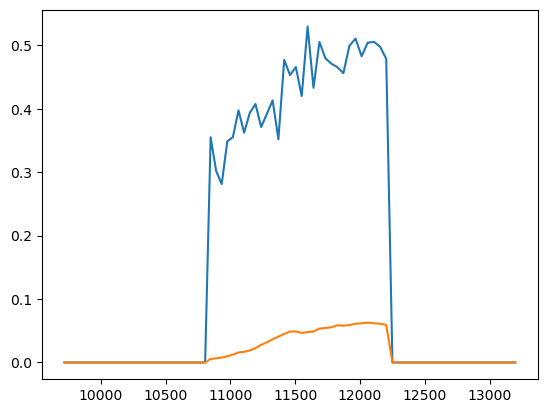

In [11]:
plt.plot(mb_R.oned_spectrum()['F115W']['wave'], mb_R.oned_spectrum()['F115W']['flux'])
plt.plot(mb_R.oned_spectrum()['F115W']['wave'], mb_R.oned_spectrum()['F115W']['contam'])

In [10]:
import matplotlib.pylab as plt

In [25]:
from astropy.io import ascii as asc

In [75]:

base_path = "/Users/knedkova/Work/2024PASSAGE/data/"+ "Par"+ str(28)+ "/Spectra/Par"+ str(28)+ "_" + str(6).zfill(5)

specnameg1_R = (base_path + ".F115W_1D_R.dat")
specnameg2_R = (base_path + ".F150W_1D_R.dat")
specnameg3_R = (base_path + ".F200W_1D_R.dat")


In [78]:
tab_blue_R = asc.read(specnameg2_R, names=["lambda","flux","ferror","contam","zero"])
tab_blue_R_contam = np.copy(tab_blue_R)
tab_blue_R_contam["flux"] = tab_blue_R["flux"] + tab_blue_R["contam"]  

In [79]:
tab_blue_R

<Table length=99>
      lambda                flux                 ferror         contam  zero
     float64              float64               float64        float64 int64
------------------ --------------------- --------------------- ------- -----
12819.201485620451 1.232067831315147e-21 5.016545169530969e-21     0.0     0
12857.662061275081 1.232067831315147e-21 5.016545169530969e-21     0.0     0
12896.238018570266 1.232067831315147e-21 5.016545169530969e-21     0.0     0
12934.929703650672 1.232067831315147e-21 5.016545169530969e-21     0.0     0
12973.737463699392 1.232067831315147e-21 5.016545169530969e-21     0.0     0
13012.661646941073 1.232067831315147e-21 5.016545169530969e-21     0.0     0
 13051.70260264503 1.232067831315147e-21 5.016545169530969e-21     0.0     0
13090.860681128388 1.232067831315147e-21 5.016545169530969e-21     0.0     0
13130.136233759222 1.232067831315147e-21 5.016545169530969e-21     0.0     0
               ...                   ...                   ...     ...   ...
16736.007200170876 1.232067831315147e-21 5.016545169530969e-21     0.0     0
 16786.21818416955 1.232067831315147e-21 5.016545169530969e-21     0.0     0
16836.579801007407 1.232067831315147e-21 5.016545169530969e-21     0.0     0
 16887.09250258264 1.232067831315147e-21 5.016545169530969e-21     0.0     0
16937.756742149115 1.232067831315147e-21 5.016545169530969e-21     0.0     0
16988.572974320465 1.232067831315147e-21 5.016545169530969e-21     0.0     0
17039.541655074165 1.232067831315147e-21 5.016545169530969e-21     0.0     0
17090.663241755617 1.232067831315147e-21 5.016545169530969e-21     0.0     0
 17141.93819308226 1.232067831315147e-21 5.016545169530969e-21     0.0     0
 17193.36696914769 1.232067831315147e-21 5.016545169530969e-21     0.0     0

In [61]:
tab_blue_R_contam["flux"] = tab_blue_R["flux"] + tab_blue_R["contam"]  

In [62]:
tab_blue_R_contam

<Table length=139>
      lambda         flux          ferror          contam  zero
     float64       float64        float64         float64 int64
------------------ ------- ---------------------- ------- -----
 16818.99609744206     0.0 5.2211980925903045e-21     0.0     0
16857.031248307125     0.0 5.2211980925903045e-21     0.0     0
16895.152408270704     0.0 5.2211980925903045e-21     0.0     0
 16933.35977182565     0.0 5.2211980925903045e-21     0.0     0
16971.653533904624     0.0 5.2211980925903045e-21     0.0     0
17010.033889881088     0.0 5.2211980925903045e-21     0.0     0
17048.501035570305     0.0 5.2211980925903045e-21     0.0     0
 17087.05516723034     0.0 5.2211980925903045e-21     0.0     0
 17125.69648156305     0.0 5.2211980925903045e-21     0.0     0
               ...     ...                    ...     ...   ...
  22508.7267661933     0.0 5.2211980925903045e-21     0.0     0
22559.628136712276     0.0 5.2211980925903045e-21     0.0     0
22610.644610783933     0.0 5.2211980925903045e-21     0.0     0
22661.776448692577     0.0 5.2211980925903045e-21     0.0     0
22713.023911311095     0.0 5.2211980925903045e-21     0.0     0
 22764.38726010229     0.0 5.2211980925903045e-21     0.0     0
 22815.86675712021     0.0 5.2211980925903045e-21     0.0     0
 22867.46266501148     0.0 5.2211980925903045e-21     0.0     0
22919.175247016665     0.0 5.2211980925903045e-21     0.0     0
22971.004766971586     0.0 5.2211980925903045e-21     0.0     0

In [63]:
tab_blue_R

<Table length=139>
      lambda         flux          ferror          contam  zero
     float64       float64        float64         float64 int64
------------------ ------- ---------------------- ------- -----
 16818.99609744206     0.0 5.2211980925903045e-21     0.0     0
16857.031248307125     0.0 5.2211980925903045e-21     0.0     0
16895.152408270704     0.0 5.2211980925903045e-21     0.0     0
 16933.35977182565     0.0 5.2211980925903045e-21     0.0     0
16971.653533904624     0.0 5.2211980925903045e-21     0.0     0
17010.033889881088     0.0 5.2211980925903045e-21     0.0     0
17048.501035570305     0.0 5.2211980925903045e-21     0.0     0
 17087.05516723034     0.0 5.2211980925903045e-21     0.0     0
 17125.69648156305     0.0 5.2211980925903045e-21     0.0     0
               ...     ...                    ...     ...   ...
  22508.7267661933     0.0 5.2211980925903045e-21     0.0     0
22559.628136712276     0.0 5.2211980925903045e-21     0.0     0
22610.644610783933     0.0 5.2211980925903045e-21     0.0     0
22661.776448692577     0.0 5.2211980925903045e-21     0.0     0
22713.023911311095     0.0 5.2211980925903045e-21     0.0     0
 22764.38726010229     0.0 5.2211980925903045e-21     0.0     0
 22815.86675712021     0.0 5.2211980925903045e-21     0.0     0
 22867.46266501148     0.0 5.2211980925903045e-21     0.0     0
22919.175247016665     0.0 5.2211980925903045e-21     0.0     0
22971.004766971586     0.0 5.2211980925903045e-21     0.0     0

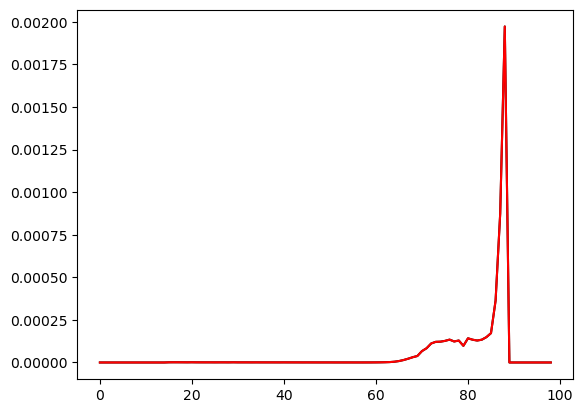

In [84]:
plt.plot( tab_blue_R_contam['flux'] - tab_blue_R['flux'], 'k-')
plt.plot( tab_blue_R_contam['contam'], 'r-')
plt.show()

In [85]:
contam

NameError: name 'contam' is not defined